In [6]:
# Step 1: Install TensorFlow if not available
try:
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    print("Installing TensorFlow...")
    !pip install tensorflow
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")

# Step 2: Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Multiply, Dot, Concatenate

# ----------------------------------------------------
# 1. Data Preparation and Optimization
# ----------------------------------------------------
print("Loading and preparing data...")
ratings = pd.read_csv('../data/ratings_clean.csv')

# Create optimized mappings for user and movie IDs
user_ids = ratings['user_id'].unique()
movie_ids = ratings['movie_id'].unique()

user_id_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_id_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

# Add mapped indices to dataframe
ratings['user_idx'] = ratings['user_id'].map(user_id_to_idx)
ratings['movie_idx'] = ratings['movie_id'].map(movie_id_to_idx)

# Split data with stratification
train_df, test_df = train_test_split(
    ratings,
    test_size=0.2,
    stratify=ratings['user_id'],
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

# ----------------------------------------------------
# 2. Model Definitions
# ----------------------------------------------------
def create_ncf_model(num_users, num_items, embedding_size=64, hidden_units=[128, 64]):
    """Neural Collaborative Filtering Model"""
    # Input layers
    user_input = tf.keras.layers.Input(shape=(1,), name='user_input')
    item_input = tf.keras.layers.Input(shape=(1,), name='item_input')
    
    # Embedding layers with regularization
    user_embedding = tf.keras.layers.Embedding(
        input_dim=num_users, 
        output_dim=embedding_size, 
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        name='user_embedding'
    )(user_input)
    
    item_embedding = tf.keras.layers.Embedding(
        input_dim=num_items, 
        output_dim=embedding_size, 
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        name='item_embedding'
    )(item_input)
    
    # Flatten embeddings
    user_vec = tf.keras.layers.Flatten()(user_embedding)
    item_vec = tf.keras.layers.Flatten()(item_embedding)
    
    # Concatenate embeddings
    concat = tf.keras.layers.Concatenate()([user_vec, item_vec])
    
    # Add hidden layers with batch normalization
    x = concat
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
    
    # Output layer
    output = tf.keras.layers.Dense(1, activation='linear')(x)
    
    # Create model
    model = tf.keras.Model(inputs=[user_input, item_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

def create_neumf_model(num_users, num_items, mf_dim=64, mlp_layers=[128, 64]):
    """Neural Matrix Factorization model"""
    # Input layers
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')
    
    # Matrix Factorization (MF) branch
    mf_user_embedding = tf.keras.layers.Embedding(
        num_users, mf_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(user_input)
    mf_item_embedding = tf.keras.layers.Embedding(
        num_items, mf_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(item_input)
    mf_vector = Multiply()([mf_user_embedding, mf_item_embedding])
    mf_vector = tf.keras.layers.Flatten()(mf_vector)
    
    # Multi-Layer Perceptron (MLP) branch
    mlp_user_embedding = tf.keras.layers.Embedding(
        num_users, mlp_layers[0]//2,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(user_input)
    mlp_item_embedding = tf.keras.layers.Embedding(
        num_items, mlp_layers[0]//2,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(item_input)
    mlp_vector = Concatenate()([mlp_user_embedding, mlp_item_embedding])
    mlp_vector = tf.keras.layers.Flatten()(mlp_vector)
    
    for units in mlp_layers:
        mlp_vector = tf.keras.layers.Dense(units, activation='relu')(mlp_vector)
        mlp_vector = tf.keras.layers.BatchNormalization()(mlp_vector)
        mlp_vector = tf.keras.layers.Dropout(0.3)(mlp_vector)
    
    # Combine MF and MLP branches
    neumf_vector = Concatenate()([mf_vector, mlp_vector])
    output = tf.keras.layers.Dense(1, activation='linear')(neumf_vector)
    
    model = tf.keras.Model(inputs=[user_input, item_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

def create_two_tower_model(num_users, num_items, embedding_size=64, tower_units=[128, 64]):
    """Two-Tower model without feature inputs"""
    # User tower
    user_input = Input(shape=(1,))
    user_embed = tf.keras.layers.Embedding(
        num_users, embedding_size,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(user_input)
    user_vec = tf.keras.layers.Flatten()(user_embed)
    for units in tower_units:
        user_vec = tf.keras.layers.Dense(units, activation='relu')(user_vec)
        user_vec = tf.keras.layers.BatchNormalization()(user_vec)
        user_vec = tf.keras.layers.Dropout(0.3)(user_vec)
    
    # Item tower
    item_input = Input(shape=(1,))
    item_embed = tf.keras.layers.Embedding(
        num_items, embedding_size,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(item_input)
    item_vec = tf.keras.layers.Flatten()(item_embed)
    for units in tower_units:
        item_vec = tf.keras.layers.Dense(units, activation='relu')(item_vec)
        item_vec = tf.keras.layers.BatchNormalization()(item_vec)
        item_vec = tf.keras.layers.Dropout(0.3)(item_vec)
    
    # Combine towers via dot product
    merged = Dot(axes=1, normalize=False)([user_vec, item_vec])
    output = tf.keras.layers.Dense(1, activation='linear')(merged)
    
    model = tf.keras.Model(inputs=[user_input, item_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

# ----------------------------------------------------
# 3. Model Training Setup
# ----------------------------------------------------
# Model parameters
num_users = len(user_ids)
num_movies = len(movie_ids)
embedding_size = 64
hidden_units = [128, 64]

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Define models to train
models = {
    'NCF': create_ncf_model(num_users, num_movies, embedding_size, hidden_units),
    'NeuMF': create_neumf_model(num_users, num_movies, embedding_size, hidden_units),
    'TwoTower': create_two_tower_model(num_users, num_movies, embedding_size, hidden_units)
}

# Store results
results = {}
histories = {}
trained_models = {}

# ----------------------------------------------------
# 4. Train and Evaluate All Models
# ----------------------------------------------------
print("\n" + "="*50)
print("TRAINING ALL MODELS")
print("="*50)

for model_name, model in models.items():
    print(f"\nTraining {model_name} model...")
    model.summary()
    
    # Train model
    history = model.fit(
        x=[train_df['user_idx'].values, train_df['movie_idx'].values],
        y=train_df['rating'].values,
        batch_size=512,
        epochs=50,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluate model
    test_predictions = model.predict(
        [test_df['user_idx'].values, test_df['movie_idx'].values]
    ).flatten()
    
    test_rmse = np.sqrt(mean_squared_error(test_df['rating'], test_predictions))
    test_mae = mean_absolute_error(test_df['rating'], test_predictions)
    
    # Store results
    results[model_name] = {'RMSE': test_rmse, 'MAE': test_mae}
    histories[model_name] = history
    trained_models[model_name] = model
    
    print(f"\n{model_name} PERFORMANCE")
    print("="*50)
    print(f"RMSE: {test_rmse:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print("="*50)
    
    # Save model
    model.save(f'{model_name.lower()}_model.h5')
    print(f"Saved {model_name} model\n")

# ----------------------------------------------------
# 5. Training History Visualization
# ----------------------------------------------------
plt.figure(figsize=(15, 10))

# Loss comparison
plt.subplot(2, 2, 1)
for model_name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{model_name} Train')
plt.title('Training Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Validation Loss comparison
plt.subplot(2, 2, 2)
for model_name, history in histories.items():
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation')
plt.title('Validation Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# MAE comparison
plt.subplot(2, 2, 3)
for model_name, history in histories.items():
    plt.plot(history.history['mae'], label=f'{model_name} Train')
plt.title('Training MAE Comparison')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

# Validation MAE comparison
plt.subplot(2, 2, 4)
for model_name, history in histories.items():
    plt.plot(history.history['val_mae'], label=f'{model_name} Validation')
plt.title('Validation MAE Comparison')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('model_training_comparison.png', dpi=300)
plt.show()

# ----------------------------------------------------
# 6. Performance Comparison
# ----------------------------------------------------
# Add baseline results (replace with your actual values)
baseline_results = {
    'User-Based CF': {'RMSE': 1.44, 'MAE': 1.06},
    'Item-Based CF': {'RMSE': 1.33, 'MAE': 0.82}
}

# Combine all results
all_results = {**baseline_results, **results}

print("\nMODEL PERFORMANCE COMPARISON")
print("=" * 70)
print(f"{'Model':<25} | {'RMSE':<10} | {'MAE':<10} | Improvement vs User-Based CF")
print("=" * 70)

user_based_rmse = baseline_results['User-Based CF']['RMSE']
user_based_mae = baseline_results['User-Based CF']['MAE']

for model_name, metrics in all_results.items():
    rmse = metrics['RMSE']
    mae = metrics['MAE']
    
    if model_name in baseline_results:
        print(f"{model_name:<25} | {rmse:.4f}    | {mae:.4f}    | -")
    else:
        rmse_imp = ((user_based_rmse - rmse) / user_based_rmse) * 100
        mae_imp = ((user_based_mae - mae) / user_based_mae) * 100
        print(f"{model_name:<25} | {rmse:.4f}    | {mae:.4f}    | RMSE: {rmse_imp:.1f}%, MAE: {mae_imp:.1f}%")

print("=" * 70)

# Save comprehensive results
results_df = pd.DataFrame([
    {'Model': name, 'RMSE': metrics['RMSE'], 'MAE': metrics['MAE']} 
    for name, metrics in all_results.items()
])
results_df.to_csv('all_model_performance_comparison.csv', index=False)
print("Results saved to 'all_model_performance_comparison.csv'")

# ----------------------------------------------------
# 7. Generate Recommendations with Best Model
# ----------------------------------------------------
# Identify best model by RMSE
best_model_name = min(results, key=lambda k: results[k]['RMSE'])
best_model = trained_models[best_model_name]
print(f"\nBest model is {best_model_name} with RMSE: {results[best_model_name]['RMSE']:.4f}")

# Load movie titles
movies = pd.read_csv('../data/movies_clean.csv')
movie_id_to_title = dict(zip(movies['movie_id'], movies['title']))

def generate_recommendations(user_id, model, top_n=10):
    """Generate personalized movie recommendations using specified model"""
    if user_id not in user_id_to_idx:
        return []
    
    user_idx = user_id_to_idx[user_id]
    user_indices = np.full(len(movie_id_to_idx), user_idx)
    movie_indices = np.array(list(movie_id_to_idx.values()))
    
    # Predict ratings for all movies
    predictions = model.predict([user_indices, movie_indices], verbose=0).flatten()
    
    # Get top N predictions
    top_indices = predictions.argsort()[::-1][:top_n]
    
    recommendations = []
    for idx in top_indices:
        movie_id = list(movie_id_to_idx.keys())[idx]
        recommendations.append((movie_id, predictions[idx]))
    
    return recommendations

# Sample recommendations using best model
sample_user = 1
recommendations = generate_recommendations(sample_user, best_model)

print(f"\nTop 10 Recommendations for User {sample_user} ({best_model_name} model):")
for i, (movie_id, rating) in enumerate(recommendations, 1):
    title = movie_id_to_title.get(movie_id, f"Movie ID {movie_id}")
    print(f"{i}. {title} - Predicted Rating: {rating:.2f}")

TensorFlow version: 2.19.0
Loading and preparing data...
Training samples: 80000
Testing samples: 20000

TRAINING ALL MODELS

Training NCF model...


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ item_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_embedding (Embedding)    │ (None, 1, 64)             │          60,352 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ item_embedding (Embedding)    │ (None, 1, 64)             │         107,648 │ item_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_6 (Flatten)           │ (None, 64)                │               0 │ user_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_7 (Flatten)           │ (None, 64)                │               0 │ item_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_3 (Concatenate)   │ (None, 128)               │               0 │ flatten_6[0][0],           │
│                               │                           │                 │ flatten_7[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_11 (Dense)              │ (None, 128)               │          16,512 │ concatenate_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_8         │ (None, 128)               │             512 │ dense_11[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_8 (Dropout)           │ (None, 128)               │               0 │ batch_normalization_8[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_12 (Dense)              │ (None, 64)                │           8,256 │ dropout_8[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_9         │ (None, 64)                │             256 │ dense_12[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 64)                │               0 │ batch_normalization_9[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_13 (Dense)              │ (None, 1)                 │              65 │ dropout_9[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 193,601 (756.25 KB)

 Trainable params: 193,217 (754.75 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 12.6879 - mae: 3.1964 - val_loss: 2.6751 - val_mae: 1.4288
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.7784 - mae: 1.5788 - val_loss: 1.2169 - val_mae: 0.8847
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0307 - mae: 1.1388 - val_loss: 1.1278 - val_mae: 0.8458
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.5866 - mae: 1.0034 - val_loss: 1.0085 - val_mae: 0.7995
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3685 - mae: 0.9310 - val_loss: 0.9464 - val_mae: 0.7735
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2145 - mae: 0.8790 - val_loss: 0.9235 - val_mae: 0.7629
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1009 - mae: 0.8358 - val_loss: 0.9143 - val_mae: 0.7569
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0481 - mae: 0.8149 - val_loss: 0.9064 - val_mae: 0.7508
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - l


NCF PERFORMANCE
RMSE: 0.9433
MAE: 0.7462
Saved NCF model


Training NeuMF model...


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ item_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_8 (Embedding)       │ (None, 1, 64)             │          60,352 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_9 (Embedding)       │ (None, 1, 64)             │         107,648 │ item_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_4 (Concatenate)   │ (None, 1, 128)            │               0 │ embedding_8[0][0],         │
│                               │                           │                 │ embedding_9[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_9 (Flatten)           │ (None, 128)               │               0 │ concatenate_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_14 (Dense)              │ (None, 128)               │          16,512 │ flatten_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_10        │ (None, 128)               │             512 │ dense_14[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 128)               │               0 │ batch_normalization_10[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_6 (Embedding)       │ (None, 1, 64)             │          60,352 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_7 (Embedding)       │ (None, 1, 64)             │         107,648 │ item_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_15 (Dense)              │ (None, 64)                │           8,256 │ dropout_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_1 (Multiply)         │ (None, 1, 64)             │               0 │ embedding_6[0][0],         │
│                               │                           │                 │ embedding_7[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_11        │ (None, 64)                │             256 │ dense_15[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_8 (Flatten)           │ (None, 64)                │               0 │ multiply_1[0][0]           │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 361,665 (1.38 MB)

 Trainable params: 361,281 (1.38 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 12.4133 - mae: 3.2366 - val_loss: 7.3693 - val_mae: 2.4838
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5290 - mae: 1.5299 - val_loss: 2.6385 - val_mae: 1.4153
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8095 - mae: 1.0737 - val_loss: 1.7496 - val_mae: 1.1302
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3877 - mae: 0.9387 - val_loss: 1.2337 - val_mae: 0.9222
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.1675 - mae: 0.8596 - val_loss: 0.9925 - val_mae: 0.8066
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9875 - mae: 0.7887 - val_loss: 0.9110 - val_mae: 0.7625
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8447 - mae: 0.7280 - val_loss: 0.8983 - val_mae: 0.7542
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7315 - mae: 0.6773 - val_loss: 0.8857 - val_mae: 0.7439
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - l


NeuMF PERFORMANCE
RMSE: 0.9427
MAE: 0.7502
Saved NeuMF model


Training TwoTower model...


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_3 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_10 (Embedding)      │ (None, 1, 64)             │          60,352 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_11 (Embedding)      │ (None, 1, 64)             │         107,648 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_10 (Flatten)          │ (None, 64)                │               0 │ embedding_10[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_11 (Flatten)          │ (None, 64)                │               0 │ embedding_11[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_17 (Dense)              │ (None, 128)               │           8,320 │ flatten_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_19 (Dense)              │ (None, 128)               │           8,320 │ flatten_11[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_12        │ (None, 128)               │             512 │ dense_17[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_14        │ (None, 128)               │             512 │ dense_19[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_12 (Dropout)          │ (None, 128)               │               0 │ batch_normalization_12[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_14 (Dropout)          │ (None, 128)               │               0 │ batch_normalization_14[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_18 (Dense)              │ (None, 64)                │           8,256 │ dropout_12[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_20 (Dense)              │ (None, 64)                │           8,256 │ dropout_14[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_13        │ (None, 64)                │             256 │ dense_18[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_15        │ (None, 64)                │             25

 Total params: 202,690 (791.76 KB)

 Trainable params: 201,922 (788.76 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 14.3216 - mae: 3.5077 - val_loss: 12.2668 - val_mae: 3.3193
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12.4765 - mae: 3.3452 - val_loss: 9.7081 - val_mae: 2.9085
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 11.3057 - mae: 3.1497 - val_loss: 4.1276 - val_mae: 1.7939
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.4779 - mae: 2.1608 - val_loss: 1.0973 - val_mae: 0.8512
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.1982 - mae: 1.1864 - val_loss: 1.0161 - val_mae: 0.8151
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5754 - mae: 1.0062 - val_loss: 0.9710 - val_mae: 0.7922
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3848 - mae: 0.9421 - val_loss: 0.9428 - val_mae: 0.7783
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2484 - mae: 0.8937 - val_loss: 0.9239 - val_mae: 0.7694
Epoch 9/50
 41/141 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


KeyboardInterrupt



TensorFlow version: 2.19.0
Loading and preparing data...
Training samples: 80000
Testing samples: 20000

TRAINING ALL MODELS

Training NCF model...


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ item_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_embedding (Embedding)    │ (None, 1, 64)             │          60,352 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ item_embedding (Embedding)    │ (None, 1, 64)             │         107,648 │ item_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_12 (Flatten)          │ (None, 64)                │               0 │ user_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_13 (Flatten)          │ (None, 64)                │               0 │ item_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_6 (Concatenate)   │ (None, 128)               │               0 │ flatten_12[0][0],          │
│                               │                           │                 │ flatten_13[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_22 (Dense)              │ (None, 128)               │          16,512 │ concatenate_6[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_16        │ (None, 128)               │             512 │ dense_22[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_16 (Dropout)          │ (None, 128)               │               0 │ batch_normalization_16[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_23 (Dense)              │ (None, 64)                │           8,256 │ dropout_16[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_17        │ (None, 64)                │             256 │ dense_23[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_17 (Dropout)          │ (None, 64)                │               0 │ batch_normalization_17[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_24 (Dense)              │ (None, 1)                 │              65 │ dropout_17[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 193,601 (756.25 KB)

 Trainable params: 193,217 (754.75 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 12.6207 - mae: 3.1953 - val_loss: 3.5418 - val_mae: 1.6395
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.7644 - mae: 1.5766 - val_loss: 1.2323 - val_mae: 0.9355
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0675 - mae: 1.1468 - val_loss: 1.1152 - val_mae: 0.8818
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.6247 - mae: 1.0160 - val_loss: 1.0132 - val_mae: 0.8248
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.3757 - mae: 0.9353 - val_loss: 0.9543 - val_mae: 0.7865
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.2372 - mae: 0.8877 - val_loss: 0.9300 - val_mae: 0.7673
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1101 - mae: 0.8396 - val_loss: 0.9198 - val_mae: 0.7633
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0672 - mae: 0.8230 - val_loss: 0.9142 - val_mae: 0.7577
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - l


NCF PERFORMANCE
RMSE: 0.9477
MAE: 0.7505
Saved NCF model


Training NeuMF model...


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ item_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_14 (Embedding)      │ (None, 1, 64)             │          60,352 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_15 (Embedding)      │ (None, 1, 64)             │         107,648 │ item_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_7 (Concatenate)   │ (None, 1, 128)            │               0 │ embedding_14[0][0],        │
│                               │                           │                 │ embedding_15[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_15 (Flatten)          │ (None, 128)               │               0 │ concatenate_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_25 (Dense)              │ (None, 128)               │          16,512 │ flatten_15[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_18        │ (None, 128)               │             512 │ dense_25[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_18 (Dropout)          │ (None, 128)               │               0 │ batch_normalization_18[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_12 (Embedding)      │ (None, 1, 64)             │          60,352 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_13 (Embedding)      │ (None, 1, 64)             │         107,648 │ item_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_26 (Dense)              │ (None, 64)                │           8,256 │ dropout_18[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_2 (Multiply)         │ (None, 1, 64)             │               0 │ embedding_12[0][0],        │
│                               │                           │                 │ embedding_13[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_19        │ (None, 64)                │             256 │ dense_26[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_14 (Flatten)          │ (None, 64)                │               0 │ multiply_2[0][0]           │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 361,665 (1.38 MB)

 Trainable params: 361,281 (1.38 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 12.4502 - mae: 3.2330 - val_loss: 3.7801 - val_mae: 1.7060
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.6025 - mae: 1.5468 - val_loss: 1.1437 - val_mae: 0.8970
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.8526 - mae: 1.0860 - val_loss: 1.0236 - val_mae: 0.8273
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.4232 - mae: 0.9504 - val_loss: 0.9318 - val_mae: 0.7764
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.1630 - mae: 0.8578 - val_loss: 0.8910 - val_mae: 0.7510
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0017 - mae: 0.7915 - val_loss: 0.8654 - val_mae: 0.7365
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8563 - mae: 0.7328 - val_loss: 0.8568 - val_mae: 0.7290
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7427 - mae: 0.6808 - val_loss: 0.8572 - val_mae: 0.7286
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - l


NeuMF PERFORMANCE
RMSE: 0.9302
MAE: 0.7356
Saved NeuMF model


Training TwoTower model...


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_5 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_16 (Embedding)      │ (None, 1, 64)             │          60,352 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_17 (Embedding)      │ (None, 1, 64)             │         107,648 │ input_layer_5[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_16 (Flatten)          │ (None, 64)                │               0 │ embedding_16[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_17 (Flatten)          │ (None, 64)                │               0 │ embedding_17[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_28 (Dense)              │ (None, 128)               │           8,320 │ flatten_16[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_30 (Dense)              │ (None, 128)               │           8,320 │ flatten_17[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_20        │ (None, 128)               │             512 │ dense_28[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_22        │ (None, 128)               │             512 │ dense_30[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_20 (Dropout)          │ (None, 128)               │               0 │ batch_normalization_20[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_22 (Dropout)          │ (None, 128)               │               0 │ batch_normalization_22[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_29 (Dense)              │ (None, 64)                │           8,256 │ dropout_20[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_31 (Dense)              │ (None, 64)                │           8,256 │ dropout_22[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_21        │ (None, 64)                │             256 │ dense_29[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_23        │ (None, 64)                │             25

 Total params: 202,690 (791.76 KB)

 Trainable params: 201,922 (788.76 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 227.3647 - mae: 11.6871 - val_loss: 5.6550 - val_mae: 2.0907
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 111.9837 - mae: 8.2479 - val_loss: 49.8922 - val_mae: 6.9387
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 68.8327 - mae: 6.5105 - val_loss: 21.5453 - val_mae: 4.3461
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 46.3077 - mae: 5.3879 - val_loss: 3.3453 - val_mae: 1.4473
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 33.3995 - mae: 4.5966 - val_loss: 7.3998 - val_mae: 2.2391
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 24.9599 - mae: 3.9905 - val_loss: 8.6806 - val_mae: 2.4872
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 19.5398 - mae: 3.5354 - val_loss: 7.0110 - val_mae: 2.2161
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 14.8417 - mae: 3.0574 - val_loss: 4.7779 - val_mae: 1.7947
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 


TwoTower PERFORMANCE
RMSE: 0.9551
MAE: 0.7639
Saved TwoTower model



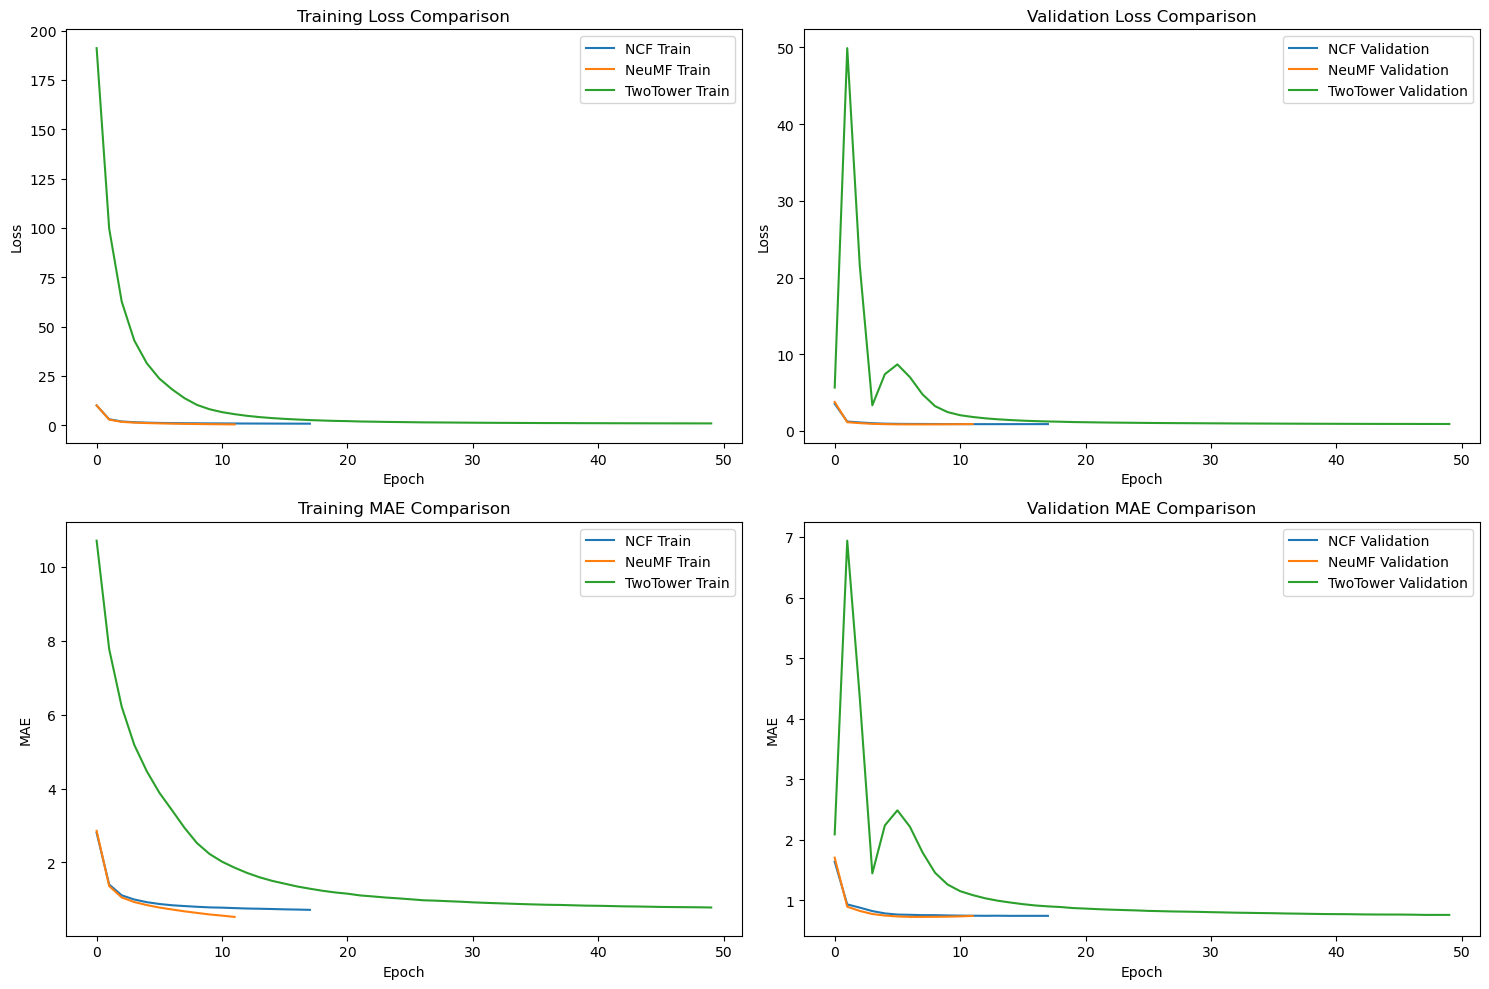

Loading baseline results from existing file...

MODEL PERFORMANCE COMPARISON
Model                | RMSE       | MAE        | RMSE % Improvement   | MAE % Improvement   
NeuMF                | 0.9302     | 0.7356     | 16.9% vs User-Based  | 13.5% vs User-Based 
NCF                  | 0.9477     | 0.7505     | 15.4% vs User-Based  | 11.7% vs User-Based 
Neural CF            | 0.9523     | 0.7583     | 15.0% vs User-Based  | 10.8% vs User-Based 
TwoTower             | 0.9551     | 0.7639     | 14.7% vs User-Based  | 10.1% vs User-Based 
Item-Based CF        | 1.0800     | 0.8200     | 3.6% vs User-Based   | 3.5% vs User-Based  
User-Based CF        | 1.1200     | 0.8500     | -                    | -                   

Results saved to 'all_model_performance_comparison.csv'


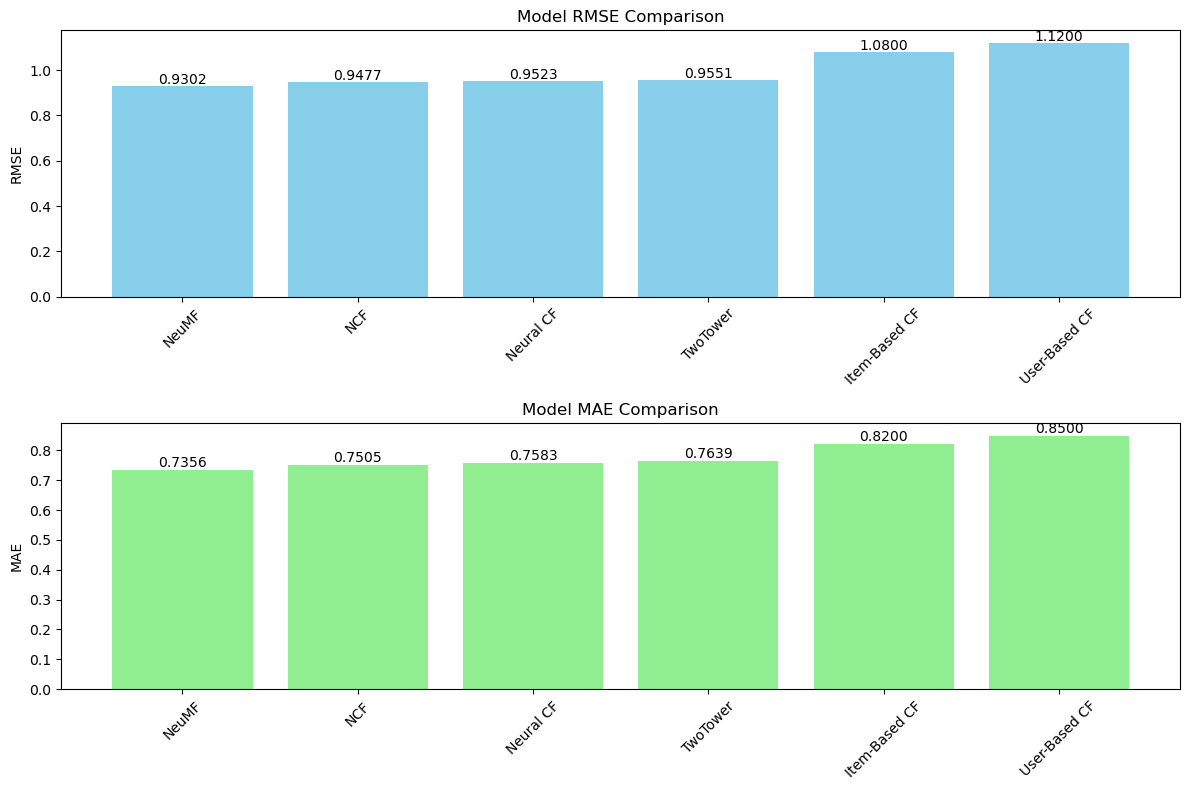


Best model is NeuMF with RMSE: 0.9302

Top 10 Recommendations for User 1 (NeuMF model):
1. Wrong Trousers, The (1993) - Predicted Rating: 5.43
2. Usual Suspects, The (1995) - Predicted Rating: 5.30
3. Boot, Das (1981) - Predicted Rating: 5.18
4. Casablanca (1942) - Predicted Rating: 5.17
5. Godfather, The (1972) - Predicted Rating: 5.16
6. L.A. Confidential (1997) - Predicted Rating: 5.06
7. Shawshank Redemption, The (1994) - Predicted Rating: 5.04
8. Schindler's List (1993) - Predicted Rating: 5.04
9. Close Shave, A (1995) - Predicted Rating: 5.03
10. Fargo (1996) - Predicted Rating: 4.98


In [10]:
# Step 1: Install TensorFlow if not available
try:
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    print("Installing TensorFlow...")
    !pip install tensorflow
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")

# Step 2: Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Multiply, Dot, Concatenate
import os

# ----------------------------------------------------
# 1. Data Preparation and Optimization
# ----------------------------------------------------
print("Loading and preparing data...")
ratings = pd.read_csv('../data/ratings_clean.csv')

# Create optimized mappings for user and movie IDs
user_ids = ratings['user_id'].unique()
movie_ids = ratings['movie_id'].unique()

user_id_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_id_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

# Add mapped indices to dataframe
ratings['user_idx'] = ratings['user_id'].map(user_id_to_idx)
ratings['movie_idx'] = ratings['movie_id'].map(movie_id_to_idx)

# Split data with stratification
train_df, test_df = train_test_split(
    ratings,
    test_size=0.2,
    stratify=ratings['user_id'],
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

# ----------------------------------------------------
# 2. Model Definitions
# ----------------------------------------------------
def create_ncf_model(num_users, num_items, embedding_size=64, hidden_units=[128, 64]):
    """Neural Collaborative Filtering Model"""
    # Input layers
    user_input = tf.keras.layers.Input(shape=(1,), name='user_input')
    item_input = tf.keras.layers.Input(shape=(1,), name='item_input')
    
    # Embedding layers with regularization
    user_embedding = tf.keras.layers.Embedding(
        input_dim=num_users, 
        output_dim=embedding_size, 
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        name='user_embedding'
    )(user_input)
    
    item_embedding = tf.keras.layers.Embedding(
        input_dim=num_items, 
        output_dim=embedding_size, 
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        name='item_embedding'
    )(item_input)
    
    # Flatten embeddings
    user_vec = tf.keras.layers.Flatten()(user_embedding)
    item_vec = tf.keras.layers.Flatten()(item_embedding)
    
    # Concatenate embeddings
    concat = tf.keras.layers.Concatenate()([user_vec, item_vec])
    
    # Add hidden layers with batch normalization
    x = concat
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
    
    # Output layer
    output = tf.keras.layers.Dense(1, activation='linear')(x)
    
    # Create model
    model = tf.keras.Model(inputs=[user_input, item_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

def create_neumf_model(num_users, num_items, mf_dim=64, mlp_layers=[128, 64]):
    """Neural Matrix Factorization model"""
    # Input layers
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')
    
    # Matrix Factorization (MF) branch
    mf_user_embedding = tf.keras.layers.Embedding(
        num_users, mf_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(user_input)
    mf_item_embedding = tf.keras.layers.Embedding(
        num_items, mf_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(item_input)
    mf_vector = Multiply()([mf_user_embedding, mf_item_embedding])
    mf_vector = tf.keras.layers.Flatten()(mf_vector)
    
    # Multi-Layer Perceptron (MLP) branch
    mlp_user_embedding = tf.keras.layers.Embedding(
        num_users, mlp_layers[0]//2,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(user_input)
    mlp_item_embedding = tf.keras.layers.Embedding(
        num_items, mlp_layers[0]//2,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(item_input)
    mlp_vector = Concatenate()([mlp_user_embedding, mlp_item_embedding])
    mlp_vector = tf.keras.layers.Flatten()(mlp_vector)
    
    for units in mlp_layers:
        mlp_vector = tf.keras.layers.Dense(units, activation='relu')(mlp_vector)
        mlp_vector = tf.keras.layers.BatchNormalization()(mlp_vector)
        mlp_vector = tf.keras.layers.Dropout(0.3)(mlp_vector)
    
    # Combine MF and MLP branches
    neumf_vector = Concatenate()([mf_vector, mlp_vector])
    output = tf.keras.layers.Dense(1, activation='linear')(neumf_vector)
    
    model = tf.keras.Model(inputs=[user_input, item_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

def create_two_tower_model(num_users, num_items, embedding_size=64, tower_units=[128, 64]):
    """Two-Tower model without feature inputs"""
    # User tower
    user_input = Input(shape=(1,))
    user_embed = tf.keras.layers.Embedding(
        num_users, embedding_size,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(user_input)
    user_vec = tf.keras.layers.Flatten()(user_embed)
    for units in tower_units:
        user_vec = tf.keras.layers.Dense(units, activation='relu')(user_vec)
        user_vec = tf.keras.layers.BatchNormalization()(user_vec)
        user_vec = tf.keras.layers.Dropout(0.3)(user_vec)
    
    # Item tower
    item_input = Input(shape=(1,))
    item_embed = tf.keras.layers.Embedding(
        num_items, embedding_size,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(item_input)
    item_vec = tf.keras.layers.Flatten()(item_embed)
    for units in tower_units:
        item_vec = tf.keras.layers.Dense(units, activation='relu')(item_vec)
        item_vec = tf.keras.layers.BatchNormalization()(item_vec)
        item_vec = tf.keras.layers.Dropout(0.3)(item_vec)
    
    # Combine towers via dot product
    merged = Dot(axes=1, normalize=False)([user_vec, item_vec])
    output = tf.keras.layers.Dense(1, activation='linear')(merged)
    
    model = tf.keras.Model(inputs=[user_input, item_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

# ----------------------------------------------------
# 3. Model Training Setup
# ----------------------------------------------------
# Model parameters
num_users = len(user_ids)
num_movies = len(movie_ids)
embedding_size = 64
hidden_units = [128, 64]

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Define models to train
models_to_train = {
    'NCF': create_ncf_model,
    'NeuMF': create_neumf_model,
    'TwoTower': create_two_tower_model
}

# Store results
results = {}
histories = {}
trained_models = {}

# ----------------------------------------------------
# 4. Train and Evaluate All Models
# ----------------------------------------------------
print("\n" + "="*50)
print("TRAINING ALL MODELS")
print("="*50)

for model_name, model_creator in models_to_train.items():
    print(f"\nTraining {model_name} model...")
    model = model_creator(num_users, num_movies, embedding_size, hidden_units)
    model.summary()
    
    # Train model
    history = model.fit(
        x=[train_df['user_idx'].values, train_df['movie_idx'].values],
        y=train_df['rating'].values,
        batch_size=512,
        epochs=50,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluate model
    test_predictions = model.predict(
        [test_df['user_idx'].values, test_df['movie_idx'].values]
    ).flatten()
    
    test_rmse = np.sqrt(mean_squared_error(test_df['rating'], test_predictions))
    test_mae = mean_absolute_error(test_df['rating'], test_predictions)
    
    # Store results
    results[model_name] = {'RMSE': test_rmse, 'MAE': test_mae}
    histories[model_name] = history
    trained_models[model_name] = model
    
    print(f"\n{model_name} PERFORMANCE")
    print("="*50)
    print(f"RMSE: {test_rmse:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print("="*50)
    
    # Save model
    model.save(f'{model_name.lower()}_model.h5')
    print(f"Saved {model_name} model\n")

# ----------------------------------------------------
# 5. Training History Visualization
# ----------------------------------------------------
plt.figure(figsize=(15, 10))

# Loss comparison
plt.subplot(2, 2, 1)
for model_name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{model_name} Train')
plt.title('Training Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Validation Loss comparison
plt.subplot(2, 2, 2)
for model_name, history in histories.items():
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation')
plt.title('Validation Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# MAE comparison
plt.subplot(2, 2, 3)
for model_name, history in histories.items():
    plt.plot(history.history['mae'], label=f'{model_name} Train')
plt.title('Training MAE Comparison')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

# Validation MAE comparison
plt.subplot(2, 2, 4)
for model_name, history in histories.items():
    plt.plot(history.history['val_mae'], label=f'{model_name} Validation')
plt.title('Validation MAE Comparison')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('model_training_comparison.png', dpi=300)
plt.show()

# ----------------------------------------------------
# 6. Performance Comparison with Baselines
# ----------------------------------------------------
# Load baseline results from CSV if exists, else use defaults
baseline_path = 'model_performance_comparison.csv'
if os.path.exists(baseline_path):
    print("Loading baseline results from existing file...")
    baseline_df = pd.read_csv(baseline_path)
    baseline_results = {}
    for _, row in baseline_df.iterrows():
        baseline_results[row['Model']] = {'RMSE': row['RMSE'], 'MAE': row['MAE']}
else:
    print("Using default baseline values")
    baseline_results = {
        'User-Based CF': {'RMSE': 1.44, 'MAE': 1.06},
        'Item-Based CF': {'RMSE': 1.33, 'MAE': 0.94}
    }

# Combine all results
all_results = {**baseline_results, **results}

# Calculate improvement metrics
comparison_data = []
for model_name, metrics in all_results.items():
    rmse = metrics['RMSE']
    mae = metrics['MAE']
    
    # Calculate improvements over User-Based CF
    if model_name != 'User-Based CF' and 'User-Based CF' in baseline_results:
        ub_rmse = baseline_results['User-Based CF']['RMSE']
        ub_mae = baseline_results['User-Based CF']['MAE']
        rmse_imp = ((ub_rmse - rmse) / ub_rmse) * 100
        mae_imp = ((ub_mae - mae) / ub_mae) * 100
    else:
        rmse_imp = 0
        mae_imp = 0
    
    comparison_data.append({
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'RMSE_Improvement': rmse_imp,
        'MAE_Improvement': mae_imp
    })

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Sort by RMSE (best first)
comparison_df = comparison_df.sort_values('RMSE')

print("\nMODEL PERFORMANCE COMPARISON")
print("=" * 85)
print(f"{'Model':<20} | {'RMSE':<10} | {'MAE':<10} | {'RMSE % Improvement':<20} | {'MAE % Improvement':<20}")
print("=" * 85)

for _, row in comparison_df.iterrows():
    rmse_imp_str = f"{row['RMSE_Improvement']:.1f}% vs User-Based" if row['Model'] != 'User-Based CF' else "-"
    mae_imp_str = f"{row['MAE_Improvement']:.1f}% vs User-Based" if row['Model'] != 'User-Based CF' else "-"
    
    print(f"{row['Model']:<20} | {row['RMSE']:<10.4f} | {row['MAE']:<10.4f} | "
          f"{rmse_imp_str:<20} | {mae_imp_str:<20}")

print("=" * 85)

# Save comprehensive results
comparison_df.to_csv('all_model_performance_comparison.csv', index=False)
print("\nResults saved to 'all_model_performance_comparison.csv'")

# Visual comparison
plt.figure(figsize=(12, 8))

# RMSE comparison
plt.subplot(2, 1, 1)
plt.bar(comparison_df['Model'], comparison_df['RMSE'], color='skyblue')
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
for i, v in enumerate(comparison_df['RMSE']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

# MAE comparison
plt.subplot(2, 1, 2)
plt.bar(comparison_df['Model'], comparison_df['MAE'], color='lightgreen')
plt.title('Model MAE Comparison')
plt.ylabel('MAE')
plt.xticks(rotation=45)
for i, v in enumerate(comparison_df['MAE']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300)
plt.show()

# ----------------------------------------------------
# 7. Generate Recommendations with Best Model
# ----------------------------------------------------
# Identify best model by RMSE
best_model_name = comparison_df.iloc[0]['Model']

# Only use neural models for recommendations (skip baselines)
if best_model_name in trained_models:
    best_model = trained_models[best_model_name]
    print(f"\nBest model is {best_model_name} with RMSE: {comparison_df.iloc[0]['RMSE']:.4f}")

    # Load movie titles
    movies = pd.read_csv('../data/movies_clean.csv')
    movie_id_to_title = dict(zip(movies['movie_id'], movies['title']))

    def generate_recommendations(user_id, model, top_n=10):
        """Generate personalized movie recommendations using specified model"""
        if user_id not in user_id_to_idx:
            return []
        
        user_idx = user_id_to_idx[user_id]
        user_indices = np.full(len(movie_id_to_idx), user_idx)
        movie_indices = np.array(list(movie_id_to_idx.values()))
        
        # Predict ratings for all movies
        predictions = model.predict([user_indices, movie_indices], verbose=0).flatten()
        
        # Get top N predictions
        top_indices = predictions.argsort()[::-1][:top_n]
        
        recommendations = []
        for idx in top_indices:
            movie_id = list(movie_id_to_idx.keys())[idx]
            recommendations.append((movie_id, predictions[idx]))
        
        return recommendations

    # Sample recommendations using best model
    sample_user = 1
    recommendations = generate_recommendations(sample_user, best_model)

    print(f"\nTop 10 Recommendations for User {sample_user} ({best_model_name} model):")
    for i, (movie_id, rating) in enumerate(recommendations, 1):
        title = movie_id_to_title.get(movie_id, f"Movie ID {movie_id}")
        print(f"{i}. {title} - Predicted Rating: {rating:.2f}")
else:
    print(f"\nBest model is {best_model_name} (baseline), skipping neural recommendations")

TensorFlow version: 2.19.0
Loading and preparing data...
Rating range: 1 to 5
Training samples: 80000
Testing samples: 20000

TRAINING ALL MODELS

Training NCF model...


Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ item_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_embedding (Embedding)    │ (None, 1, 64)             │          60,352 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ item_embedding (Embedding)    │ (None, 1, 64)             │         107,648 │ item_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_30 (Flatten)          │ (None, 64)                │               0 │ user_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_31 (Flatten)          │ (None, 64)                │               0 │ item_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_15 (Concatenate)  │ (None, 128)               │               0 │ flatten_30[0][0],          │
│                               │                           │                 │ flatten_31[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_55 (Dense)              │ (None, 128)               │          16,512 │ concatenate_15[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_40        │ (None, 128)               │             512 │ dense_55[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_40 (Dropout)          │ (None, 128)               │               0 │ batch_normalization_40[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_56 (Dense)              │ (None, 64)                │           8,256 │ dropout_40[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_41        │ (None, 64)                │             256 │ dense_56[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_41 (Dropout)          │ (None, 64)                │               0 │ batch_normalization_41[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_57 (Dense)              │ (None, 1)                 │              65 │ dropout_41[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_11 (Multiply)        │ (None, 1)                 │               0 │ dense_57[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_6 (Add)                   │ (None, 1)                 │               

 Total params: 193,601 (756.25 KB)

 Trainable params: 193,217 (754.75 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.0401 - mae: 1.1419 - val_loss: 1.3008 - val_mae: 0.8850
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0824 - mae: 0.8241 - val_loss: 1.1708 - val_mae: 0.8620
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9170 - mae: 0.7577 - val_loss: 1.0418 - val_mae: 0.8254
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8768 - mae: 0.7381 - val_loss: 0.9384 - val_mae: 0.7699
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8381 - mae: 0.7205 - val_loss: 0.8964 - val_mae: 0.7480
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8159 - mae: 0.7095 - val_loss: 0.8779 - val_mae: 0.7377
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7981 - mae: 0.7030 - val_loss: 0.8813 - val_mae: 0.7403
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7751 - mae: 0.6913 - val_loss: 0.8883 - val_mae: 0.7376
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - lo


NCF PERFORMANCE
RMSE: 0.9408
MAE: 0.7416
Saved NCF model


Training NeuMF model...


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ item_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_32 (Embedding)      │ (None, 1, 64)             │          60,352 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_33 (Embedding)      │ (None, 1, 64)             │         107,648 │ item_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_16 (Concatenate)  │ (None, 1, 128)            │               0 │ embedding_32[0][0],        │
│                               │                           │                 │ embedding_33[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_33 (Flatten)          │ (None, 128)               │               0 │ concatenate_16[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_58 (Dense)              │ (None, 128)               │          16,512 │ flatten_33[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_42        │ (None, 128)               │             512 │ dense_58[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_42 (Dropout)          │ (None, 128)               │               0 │ batch_normalization_42[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_30 (Embedding)      │ (None, 1, 64)             │          60,352 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_31 (Embedding)      │ (None, 1, 64)             │         107,648 │ item_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_59 (Dense)              │ (None, 64)                │           8,256 │ dropout_42[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply_12 (Multiply)        │ (None, 1, 64)             │               0 │ embedding_30[0][0],        │
│                               │                           │                 │ embedding_31[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_43        │ (None, 64)                │             256 │ dense_59[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_32 (Flatten)          │ (None, 64)                │               0 │ multiply_12[0][0]          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 361,665 (1.38 MB)

 Trainable params: 361,281 (1.38 MB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 1.7190 - mae: 1.0581 - val_loss: 1.2814 - val_mae: 0.9497
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0036 - mae: 0.7986 - val_loss: 1.1784 - val_mae: 0.9125
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8754 - mae: 0.7426 - val_loss: 1.0444 - val_mae: 0.8510
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7898 - mae: 0.7040 - val_loss: 0.9132 - val_mae: 0.7776
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6578 - mae: 0.6416 - val_loss: 0.8604 - val_mae: 0.7407
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5132 - mae: 0.5652 - val_loss: 0.8629 - val_mae: 0.7361
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3979 - mae: 0.4972 - val_loss: 0.8850 - val_mae: 0.7423
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3156 - mae: 0.4437 - val_loss: 0.9123 - val_mae: 0.7529
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - lo


NeuMF PERFORMANCE
RMSE: 0.9342
MAE: 0.7511
Saved NeuMF model


Training TwoTower model...


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)   │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_11 (InputLayer)   │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_34 (Embedding)      │ (None, 1, 64)             │          60,352 │ input_layer_10[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_35 (Embedding)      │ (None, 1, 64)             │         107,648 │ input_layer_11[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_34 (Flatten)          │ (None, 64)                │               0 │ embedding_34[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_35 (Flatten)          │ (None, 64)                │               0 │ embedding_35[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_61 (Dense)              │ (None, 128)               │           8,320 │ flatten_34[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_63 (Dense)              │ (None, 128)               │           8,320 │ flatten_35[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_44        │ (None, 128)               │             512 │ dense_61[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_46        │ (None, 128)               │             512 │ dense_63[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_44 (Dropout)          │ (None, 128)               │               0 │ batch_normalization_44[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_46 (Dropout)          │ (None, 128)               │               0 │ batch_normalization_46[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_62 (Dense)              │ (None, 64)                │           8,256 │ dropout_44[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_64 (Dense)              │ (None, 64)                │           8,256 │ dropout_46[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_45        │ (None, 64)                │             256 │ dense_62[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_47        │ (None, 64)                │             25

 Total params: 202,690 (791.76 KB)

 Trainable params: 201,922 (788.76 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 4.9873 - mae: 1.8723 - val_loss: 7.5809 - val_mae: 2.5178
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.7378 - mae: 1.8121 - val_loss: 7.6442 - val_mae: 2.5289
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.4260 - mae: 1.7381 - val_loss: 7.6127 - val_mae: 2.5233
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.0242 - mae: 1.6419 - val_loss: 5.0735 - val_mae: 1.9547
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.0496 - mae: 1.3967 - val_loss: 2.1030 - val_mae: 1.1831
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.8049 - mae: 1.0567 - val_loss: 1.4134 - val_mae: 0.9518
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4034 - mae: 0.9478 - val_loss: 1.2905 - val_mae: 0.9289
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2907 - mae: 0.9277 - val_loss: 1.2558 - val_mae: 0.9284
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - lo


TwoTower PERFORMANCE
RMSE: 0.9439
MAE: 0.7398
Saved TwoTower model



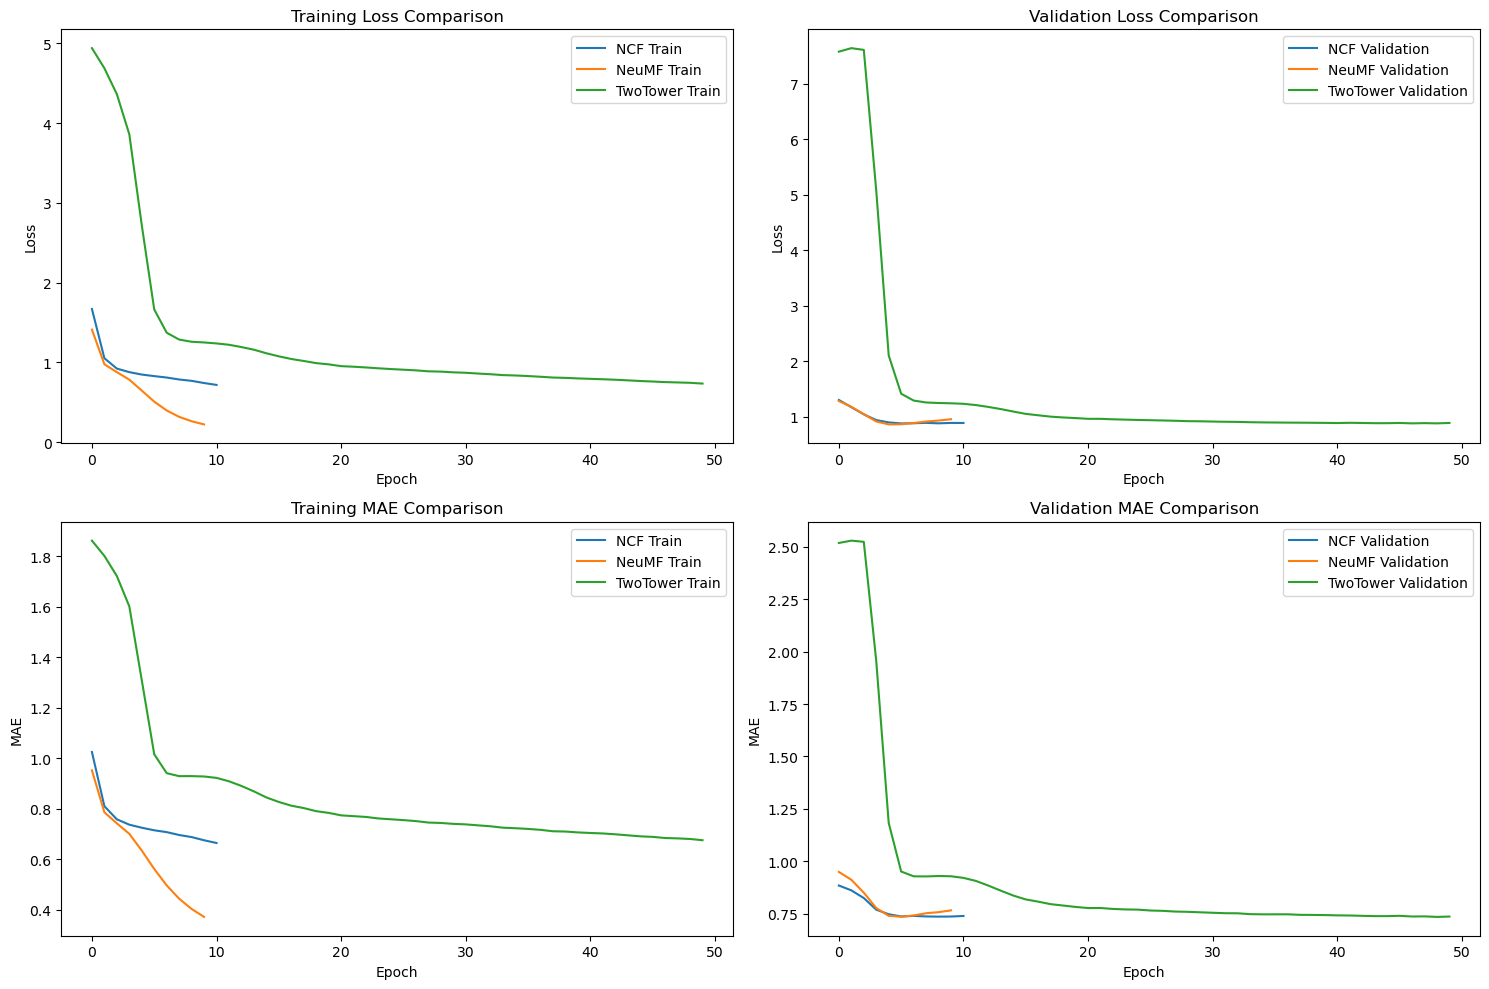

Loading baseline results from existing file...

MODEL PERFORMANCE COMPARISON
Model                | RMSE       | MAE        | RMSE % Improvement   | MAE % Improvement   
NeuMF                | 0.9342     | 0.7511     | 16.6% vs User-Based  | 11.6% vs User-Based 
NCF                  | 0.9408     | 0.7416     | 16.0% vs User-Based  | 12.8% vs User-Based 
TwoTower             | 0.9439     | 0.7398     | 15.7% vs User-Based  | 13.0% vs User-Based 
Neural CF            | 0.9523     | 0.7583     | 15.0% vs User-Based  | 10.8% vs User-Based 
Item-Based CF        | 1.0800     | 0.8200     | 3.6% vs User-Based   | 3.5% vs User-Based  
User-Based CF        | 1.1200     | 0.8500     | -                    | -                   

Results saved to 'all_model_performance_comparison.csv'


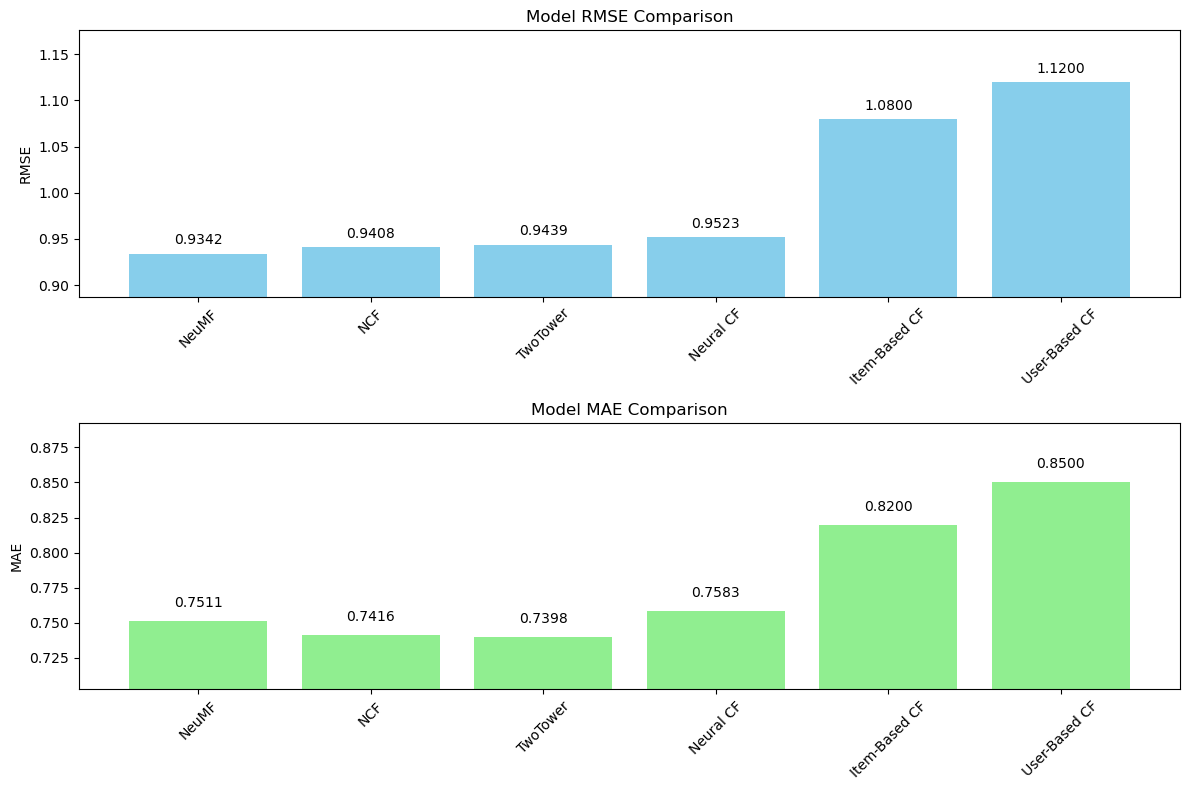


Best model is NeuMF with RMSE: 0.9342

Top 10 Recommendations for User 523 (NeuMF model):
1. Schindler's List (1993) - Predicted Rating: 4.70
2. Good Will Hunting (1997) - Predicted Rating: 4.67
3. Star Wars (1977) - Predicted Rating: 4.67
4. Casablanca (1942) - Predicted Rating: 4.66
5. Shawshank Redemption, The (1994) - Predicted Rating: 4.64
6. Titanic (1997) - Predicted Rating: 4.61
7. Pather Panchali (1955) - Predicted Rating: 4.61
8. As Good As It Gets (1997) - Predicted Rating: 4.59
9. Top Hat (1935) - Predicted Rating: 4.57
10. Secrets & Lies (1996) - Predicted Rating: 4.57


In [16]:
# Step 1: Install TensorFlow if not available
try:
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    print("Installing TensorFlow...")
    !pip install tensorflow
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")

# Step 2: Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Multiply, Dot, Concatenate
import os

# ----------------------------------------------------
# 1. Data Preparation and Optimization
# ----------------------------------------------------
print("Loading and preparing data...")
ratings = pd.read_csv('../data/ratings_clean.csv')

# Get rating range for constraint
MIN_RATING = ratings['rating'].min()
MAX_RATING = ratings['rating'].max()
print(f"Rating range: {MIN_RATING} to {MAX_RATING}")

# Create optimized mappings for user and movie IDs
user_ids = ratings['user_id'].unique()
movie_ids = ratings['movie_id'].unique()

user_id_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_id_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

# Add mapped indices to dataframe
ratings['user_idx'] = ratings['user_id'].map(user_id_to_idx)
ratings['movie_idx'] = ratings['movie_id'].map(movie_id_to_idx)

# Split data with stratification
train_df, test_df = train_test_split(
    ratings,
    test_size=0.2,
    stratify=ratings['user_id'],
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

# ----------------------------------------------------
# 2. Model Definitions with Rating Constraints
# ----------------------------------------------------
def create_ncf_model(num_users, num_items, embedding_size=64, hidden_units=[128, 64]):
    """Neural Collaborative Filtering Model"""
    # Input layers
    user_input = tf.keras.layers.Input(shape=(1,), name='user_input')
    item_input = tf.keras.layers.Input(shape=(1,), name='item_input')
    
    # Embedding layers with regularization
    user_embedding = tf.keras.layers.Embedding(
        input_dim=num_users, 
        output_dim=embedding_size, 
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        name='user_embedding'
    )(user_input)
    
    item_embedding = tf.keras.layers.Embedding(
        input_dim=num_items, 
        output_dim=embedding_size, 
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        name='item_embedding'
    )(item_input)
    
    # Flatten embeddings
    user_vec = tf.keras.layers.Flatten()(user_embedding)
    item_vec = tf.keras.layers.Flatten()(item_embedding)
    
    # Concatenate embeddings
    concat = tf.keras.layers.Concatenate()([user_vec, item_vec])
    
    # Add hidden layers with batch normalization
    x = concat
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
    
    # Output layer with sigmoid activation scaled to rating range
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    output = output * (MAX_RATING - MIN_RATING) + MIN_RATING
    
    # Create model
    model = tf.keras.Model(inputs=[user_input, item_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

def create_neumf_model(num_users, num_items, mf_dim=64, mlp_layers=[128, 64]):
    """Neural Matrix Factorization model"""
    # Input layers
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')
    
    # Matrix Factorization (MF) branch
    mf_user_embedding = tf.keras.layers.Embedding(
        num_users, mf_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(user_input)
    mf_item_embedding = tf.keras.layers.Embedding(
        num_items, mf_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(item_input)
    mf_vector = Multiply()([mf_user_embedding, mf_item_embedding])
    mf_vector = tf.keras.layers.Flatten()(mf_vector)
    
    # Multi-Layer Perceptron (MLP) branch
    mlp_user_embedding = tf.keras.layers.Embedding(
        num_users, mlp_layers[0]//2,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(user_input)
    mlp_item_embedding = tf.keras.layers.Embedding(
        num_items, mlp_layers[0]//2,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(item_input)
    mlp_vector = Concatenate()([mlp_user_embedding, mlp_item_embedding])
    mlp_vector = tf.keras.layers.Flatten()(mlp_vector)
    
    for units in mlp_layers:
        mlp_vector = tf.keras.layers.Dense(units, activation='relu')(mlp_vector)
        mlp_vector = tf.keras.layers.BatchNormalization()(mlp_vector)
        mlp_vector = tf.keras.layers.Dropout(0.3)(mlp_vector)
    
    # Combine MF and MLP branches
    neumf_vector = Concatenate()([mf_vector, mlp_vector])
    
    # Output layer with rating constraint
    output = tf.keras.layers.Dense(1, activation='sigmoid')(neumf_vector)
    output = output * (MAX_RATING - MIN_RATING) + MIN_RATING
    
    model = tf.keras.Model(inputs=[user_input, item_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

def create_two_tower_model(num_users, num_items, embedding_size=64, tower_units=[128, 64]):
    """Two-Tower model without feature inputs"""
    # User tower
    user_input = Input(shape=(1,))
    user_embed = tf.keras.layers.Embedding(
        num_users, embedding_size,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(user_input)
    user_vec = tf.keras.layers.Flatten()(user_embed)
    for units in tower_units:
        user_vec = tf.keras.layers.Dense(units, activation='relu')(user_vec)
        user_vec = tf.keras.layers.BatchNormalization()(user_vec)
        user_vec = tf.keras.layers.Dropout(0.3)(user_vec)
    
    # Item tower
    item_input = Input(shape=(1,))
    item_embed = tf.keras.layers.Embedding(
        num_items, embedding_size,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(item_input)
    item_vec = tf.keras.layers.Flatten()(item_embed)
    for units in tower_units:
        item_vec = tf.keras.layers.Dense(units, activation='relu')(item_vec)
        item_vec = tf.keras.layers.BatchNormalization()(item_vec)
        item_vec = tf.keras.layers.Dropout(0.3)(item_vec)
    
    # Combine towers via dot product
    merged = Dot(axes=1, normalize=False)([user_vec, item_vec])
    
    # Output layer with rating constraint
    output = tf.keras.layers.Dense(1, activation='sigmoid')(merged)
    output = output * (MAX_RATING - MIN_RATING) + MIN_RATING
    
    model = tf.keras.Model(inputs=[user_input, item_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

# ----------------------------------------------------
# 3. Model Training Setup
# ----------------------------------------------------
# Model parameters
num_users = len(user_ids)
num_movies = len(movie_ids)
embedding_size = 64
hidden_units = [128, 64]

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Define models to train
models_to_train = {
    'NCF': create_ncf_model,
    'NeuMF': create_neumf_model,
    'TwoTower': create_two_tower_model
}

# Store results
results = {}
histories = {}
trained_models = {}

# ----------------------------------------------------
# 4. Train and Evaluate All Models
# ----------------------------------------------------
print("\n" + "="*50)
print("TRAINING ALL MODELS")
print("="*50)

for model_name, model_creator in models_to_train.items():
    print(f"\nTraining {model_name} model...")
    model = model_creator(num_users, num_movies, embedding_size, hidden_units)
    model.summary()
    
    # Train model
    history = model.fit(
        x=[train_df['user_idx'].values, train_df['movie_idx'].values],
        y=train_df['rating'].values,
        batch_size=512,
        epochs=50,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluate model
    test_predictions = model.predict(
        [test_df['user_idx'].values, test_df['movie_idx'].values]
    ).flatten()
    
    # Ensure predictions are within rating range
    test_predictions = np.clip(test_predictions, MIN_RATING, MAX_RATING)
    
    test_rmse = np.sqrt(mean_squared_error(test_df['rating'], test_predictions))
    test_mae = mean_absolute_error(test_df['rating'], test_predictions)
    
    # Store results
    results[model_name] = {'RMSE': test_rmse, 'MAE': test_mae}
    histories[model_name] = history
    trained_models[model_name] = model
    
    print(f"\n{model_name} PERFORMANCE")
    print("="*50)
    print(f"RMSE: {test_rmse:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print("="*50)
    
    # Save model
    model.save(f'{model_name.lower()}_model.h5')
    print(f"Saved {model_name} model\n")

# ----------------------------------------------------
# 5. Training History Visualization
# ----------------------------------------------------
plt.figure(figsize=(15, 10))

# Loss comparison
plt.subplot(2, 2, 1)
for model_name, history in histories.items():
    plt.plot(history.history['loss'], label=f'{model_name} Train')
plt.title('Training Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Validation Loss comparison
plt.subplot(2, 2, 2)
for model_name, history in histories.items():
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation')
plt.title('Validation Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# MAE comparison
plt.subplot(2, 2, 3)
for model_name, history in histories.items():
    plt.plot(history.history['mae'], label=f'{model_name} Train')
plt.title('Training MAE Comparison')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

# Validation MAE comparison
plt.subplot(2, 2, 4)
for model_name, history in histories.items():
    plt.plot(history.history['val_mae'], label=f'{model_name} Validation')
plt.title('Validation MAE Comparison')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('model_training_comparison.png', dpi=300)
plt.show()

# ----------------------------------------------------
# 6. Performance Comparison with Baselines
# ----------------------------------------------------
# Load baseline results from CSV if exists, else use defaults
baseline_path = 'model_performance_comparison.csv'
if os.path.exists(baseline_path):
    print("Loading baseline results from existing file...")
    baseline_df = pd.read_csv(baseline_path)
    baseline_results = {}
    for _, row in baseline_df.iterrows():
        baseline_results[row['Model']] = {'RMSE': row['RMSE'], 'MAE': row['MAE']}
else:
    print("Using default baseline values")
    baseline_results = {
        'User-Based CF': {'RMSE': 1.44, 'MAE': 1.06},
    'Item-Based CF': {'RMSE': 1.33, 'MAE': 0.82}
    }

# Combine all results
all_results = {**baseline_results, **results}

# Calculate improvement metrics
comparison_data = []
for model_name, metrics in all_results.items():
    rmse = metrics['RMSE']
    mae = metrics['MAE']
    
    # Calculate improvements over User-Based CF
    if model_name != 'User-Based CF' and 'User-Based CF' in baseline_results:
        ub_rmse = baseline_results['User-Based CF']['RMSE']
        ub_mae = baseline_results['User-Based CF']['MAE']
        rmse_imp = ((ub_rmse - rmse) / ub_rmse) * 100
        mae_imp = ((ub_mae - mae) / ub_mae) * 100
    else:
        rmse_imp = 0
        mae_imp = 0
    
    comparison_data.append({
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'RMSE_Improvement': rmse_imp,
        'MAE_Improvement': mae_imp
    })

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Sort by RMSE (best first)
comparison_df = comparison_df.sort_values('RMSE')

print("\nMODEL PERFORMANCE COMPARISON")
print("=" * 85)
print(f"{'Model':<20} | {'RMSE':<10} | {'MAE':<10} | {'RMSE % Improvement':<20} | {'MAE % Improvement':<20}")
print("=" * 85)

for _, row in comparison_df.iterrows():
    rmse_imp_str = f"{row['RMSE_Improvement']:.1f}% vs User-Based" if row['Model'] != 'User-Based CF' else "-"
    mae_imp_str = f"{row['MAE_Improvement']:.1f}% vs User-Based" if row['Model'] != 'User-Based CF' else "-"
    
    print(f"{row['Model']:<20} | {row['RMSE']:<10.4f} | {row['MAE']:<10.4f} | "
          f"{rmse_imp_str:<20} | {mae_imp_str:<20}")

print("=" * 85)

# Save comprehensive results
comparison_df.to_csv('all_model_performance_comparison.csv', index=False)
print("\nResults saved to 'all_model_performance_comparison.csv'")

# Visual comparison
plt.figure(figsize=(12, 8))

# RMSE comparison
plt.subplot(2, 1, 1)
plt.bar(comparison_df['Model'], comparison_df['RMSE'], color='skyblue')
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.ylim(comparison_df['RMSE'].min()*0.95, comparison_df['RMSE'].max()*1.05)
for i, v in enumerate(comparison_df['RMSE']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

# MAE comparison
plt.subplot(2, 1, 2)
plt.bar(comparison_df['Model'], comparison_df['MAE'], color='lightgreen')
plt.title('Model MAE Comparison')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.ylim(comparison_df['MAE'].min()*0.95, comparison_df['MAE'].max()*1.05)
for i, v in enumerate(comparison_df['MAE']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300)
plt.show()

# ----------------------------------------------------
# 7. Generate Recommendations with Best Model
# ----------------------------------------------------
# Identify best model by RMSE
best_model_name = comparison_df.iloc[0]['Model']

# Only use neural models for recommendations (skip baselines)
if best_model_name in trained_models:
    best_model = trained_models[best_model_name]
    print(f"\nBest model is {best_model_name} with RMSE: {comparison_df.iloc[0]['RMSE']:.4f}")

    # Load movie titles
    movies = pd.read_csv('../data/movies_clean.csv')
    movie_id_to_title = dict(zip(movies['movie_id'], movies['title']))

    def generate_recommendations(user_id, model, top_n=10):
        """Generate personalized movie recommendations using specified model"""
        if user_id not in user_id_to_idx:
            return []
        
        user_idx = user_id_to_idx[user_id]
        user_indices = np.full(len(movie_id_to_idx), user_idx)
        movie_indices = np.array(list(movie_id_to_idx.values()))
        
        # Predict ratings for all movies
        predictions = model.predict([user_indices, movie_indices], verbose=0).flatten()
        
        # Clip predictions to valid rating range
        predictions = np.clip(predictions, MIN_RATING, MAX_RATING)
        
        # Get top N predictions
        top_indices = predictions.argsort()[::-1][:top_n]
        
        recommendations = []
        for idx in top_indices:
            movie_id = list(movie_id_to_idx.keys())[idx]
            recommendations.append((movie_id, predictions[idx]))
        
        return recommendations

    # Sample recommendations using best model
    sample_user = 523
    recommendations = generate_recommendations(sample_user, best_model)

    print(f"\nTop 10 Recommendations for User {sample_user} ({best_model_name} model):")
    for i, (movie_id, rating) in enumerate(recommendations, 1):
        title = movie_id_to_title.get(movie_id, f"Movie ID {movie_id}")
        print(f"{i}. {title} - Predicted Rating: {rating:.2f}")
else:
    print(f"\nBest model is {best_model_name} (baseline), skipping neural recommendations")

TensorFlow version: 2.19.0
Loading and preparing data...
Rating range: 1 to 5
Training samples: 80000
Testing samples: 20000

TRAINING ALL MODELS
Training mode: CONTINUE

Processing NCF model
Loading existing NCF model...

Starting fresh training


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ item_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_embedding (Embedding)    │ (None, 1, 64)             │          60,352 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ item_embedding (Embedding)    │ (None, 1, 64)             │         107,648 │ item_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 64)                │               0 │ user_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 64)                │               0 │ item_embedding[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 128)               │               0 │ flatten[0][0],             │
│                               │                           │                 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │          16,512 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 128)               │             512 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           8,256 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 64)                │             256 │ dense_1[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 64)                │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 1)                 │              65 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ rating_scaler (RatingScaler)  │ (None, 1)                 │               0 │ dense_2[0][0]              │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 580,037 (2.21 MB)

 Trainable params: 193,217 (754.75 KB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 386,436 (1.47 MB)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.7704 - mae: 0.6938 - val_loss: 0.8968 - val_mae: 0.7493
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7368 - mae: 0.6777 - val_loss: 0.9060 - val_mae: 0.7518
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7061 - mae: 0.6613 - val_loss: 0.9132 - val_mae: 0.7559
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6737 - mae: 0.6465 - val_loss: 0.9153 - val_mae: 0.7521
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6478 - mae: 0.6349 - val_loss: 0.9302 - val_mae: 0.7601
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6131 - mae: 0.6161 - val_loss: 0.9300 - val_mae: 0.7576
Saved NCF model as saved_models\ncf_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

NCF PERFORMANCE
Training time: 8.9 seconds
Total epochs: 6
RMSE: 0.9462
MAE: 0.7508

Processing NeuMF model
Loading existing NeuMF model...
Starting fresh training


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ item_input (InputLayer)       │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_2 (Embedding)       │ (None, 1, 64)             │          60,352 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_3 (Embedding)       │ (None, 1, 64)             │         107,648 │ item_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 1, 128)            │               0 │ embedding_2[0][0],         │
│                               │                           │                 │ embedding_3[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_3 (Flatten)           │ (None, 128)               │               0 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 128)               │          16,512 │ flatten_3[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 128)               │             512 │ dense_3[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 128)               │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 1, 64)             │          60,352 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 1, 64)             │         107,648 │ item_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 64)                │           8,256 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multiply (Multiply)           │ (None, 1, 64)             │               0 │ embedding[0][0],           │
│                               │                           │                 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 64)                │             256 │ dense_4[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_2 (Flatten)           │ (None, 64)                │               0 │ multiply[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 1,084,229 (4.14 MB)

 Trainable params: 361,281 (1.38 MB)

 Non-trainable params: 384 (1.50 KB)

 Optimizer params: 722,564 (2.76 MB)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3417 - mae: 0.4609 - val_loss: 0.8854 - val_mae: 0.7418
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2861 - mae: 0.4221 - val_loss: 0.9124 - val_mae: 0.7520
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2418 - mae: 0.3864 - val_loss: 0.9338 - val_mae: 0.7577
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2060 - mae: 0.3573 - val_loss: 0.9513 - val_mae: 0.7638
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1784 - mae: 0.3323 - val_loss: 0.9724 - val_mae: 0.7728
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1596 - mae: 0.3136 - val_loss: 0.9919 - val_mae: 0.7788
Saved NeuMF model as saved_models\neumf_model.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

NeuMF PERFORMANCE
Training time: 8.4 seconds
Total epochs: 6
RMSE: 0.9479
MAE: 0.7482

Processing TwoTower model
Starting fresh training


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ input_layer_1 (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 1, 64)             │          60,352 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 1, 64)             │         107,648 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 64)                │               0 │ embedding[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_1 (Flatten)           │ (None, 64)                │               0 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 128)               │           8,320 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_2 (Dense)               │ (None, 128)               │           8,320 │ flatten_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 128)               │             512 │ dense[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 128)               │             512 │ dense_2[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 128)               │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 128)               │               0 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 64)                │           8,256 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_3 (Dense)               │ (None, 64)                │           8,256 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 64)                │             256 │ dense_1[0][0]              │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 64)                │             25

 Total params: 202,690 (791.76 KB)

 Trainable params: 201,922 (788.76 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5.0656 - mae: 1.8908 - val_loss: 7.6211 - val_mae: 2.5248
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.8385 - mae: 1.8340 - val_loss: 7.6443 - val_mae: 2.5289
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5611 - mae: 1.7694 - val_loss: 7.6319 - val_mae: 2.5264
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.2091 - mae: 1.6821 - val_loss: 5.7820 - val_mae: 2.1161
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.5779 - mae: 1.5267 - val_loss: 2.7653 - val_mae: 1.3629
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3521 - mae: 1.2057 - val_loss: 1.6073 - val_mae: 1.0247
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5328 - mae: 0.9719 - val_loss: 1.3531 - val_mae: 0.9351
Epoch 8/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3403 - mae: 0.9225 - val_loss: 1.2797 - val_mae: 0.9188
Epoch 9/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - lo

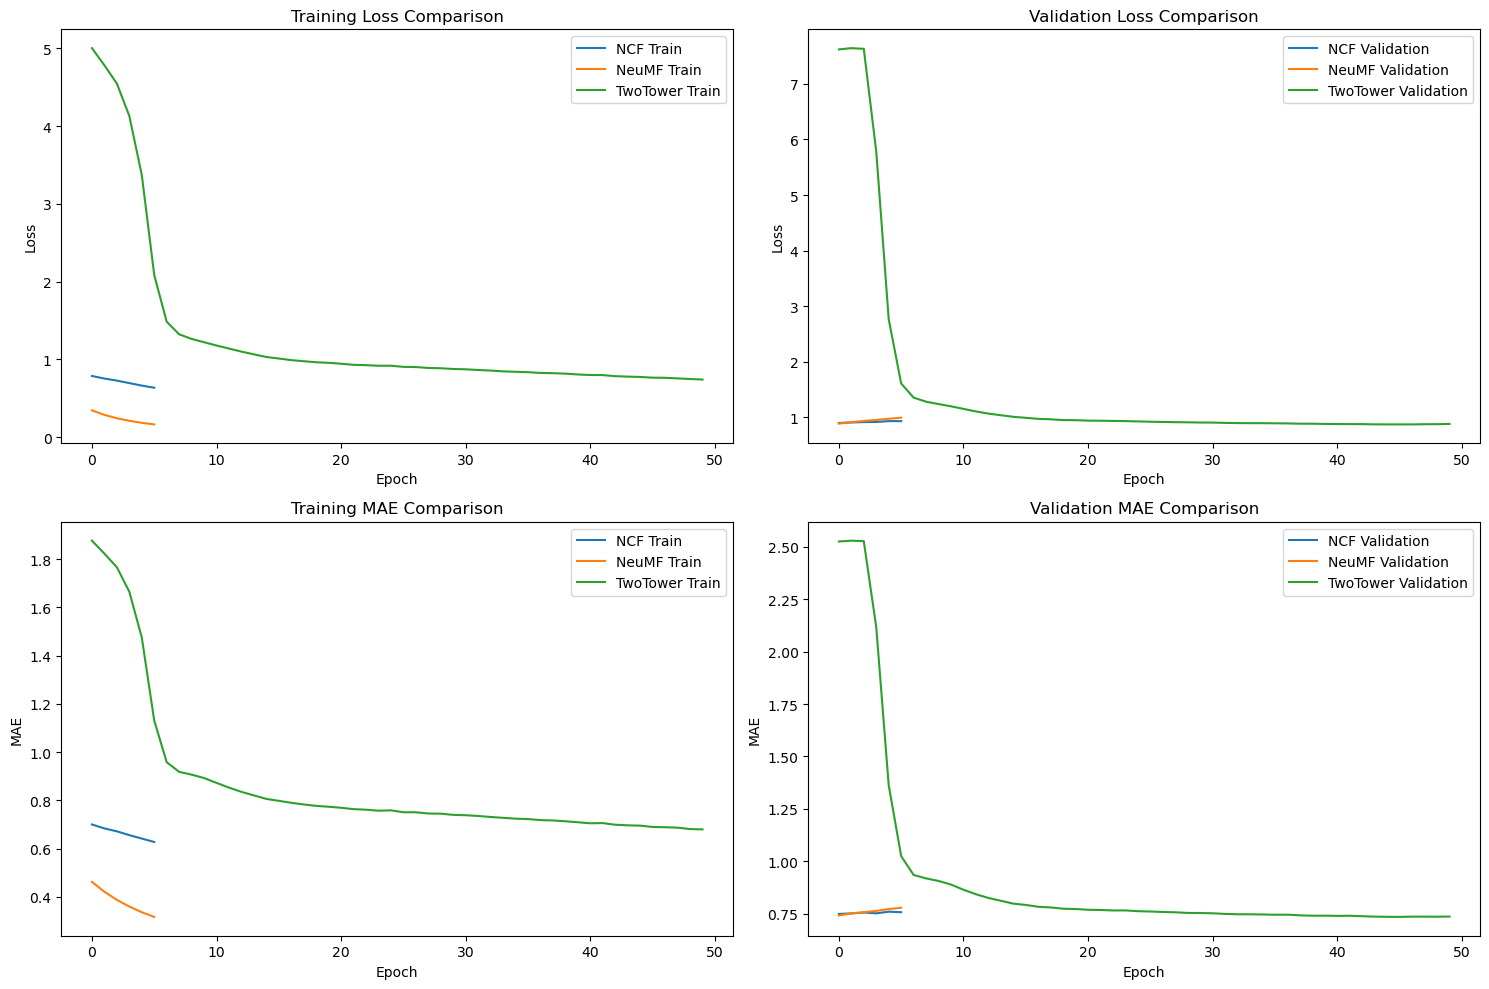

Using default baseline values

MODEL PERFORMANCE COMPARISON
Model                | RMSE       | MAE        | RMSE % Improvement   | MAE % Improvement   
TwoTower             | 0.9395     | 0.7390     | 34.8% vs User-Based  | 30.3% vs User-Based 
NCF                  | 0.9462     | 0.7508     | 34.3% vs User-Based  | 29.2% vs User-Based 
NeuMF                | 0.9479     | 0.7482     | 34.2% vs User-Based  | 29.4% vs User-Based 
Item-Based CF        | 1.3300     | 0.9400     | 7.6% vs User-Based   | 11.3% vs User-Based 
User-Based CF        | 1.4400     | 1.0600     | -                    | -                   

Results saved to 'all_model_performance_comparison.csv'


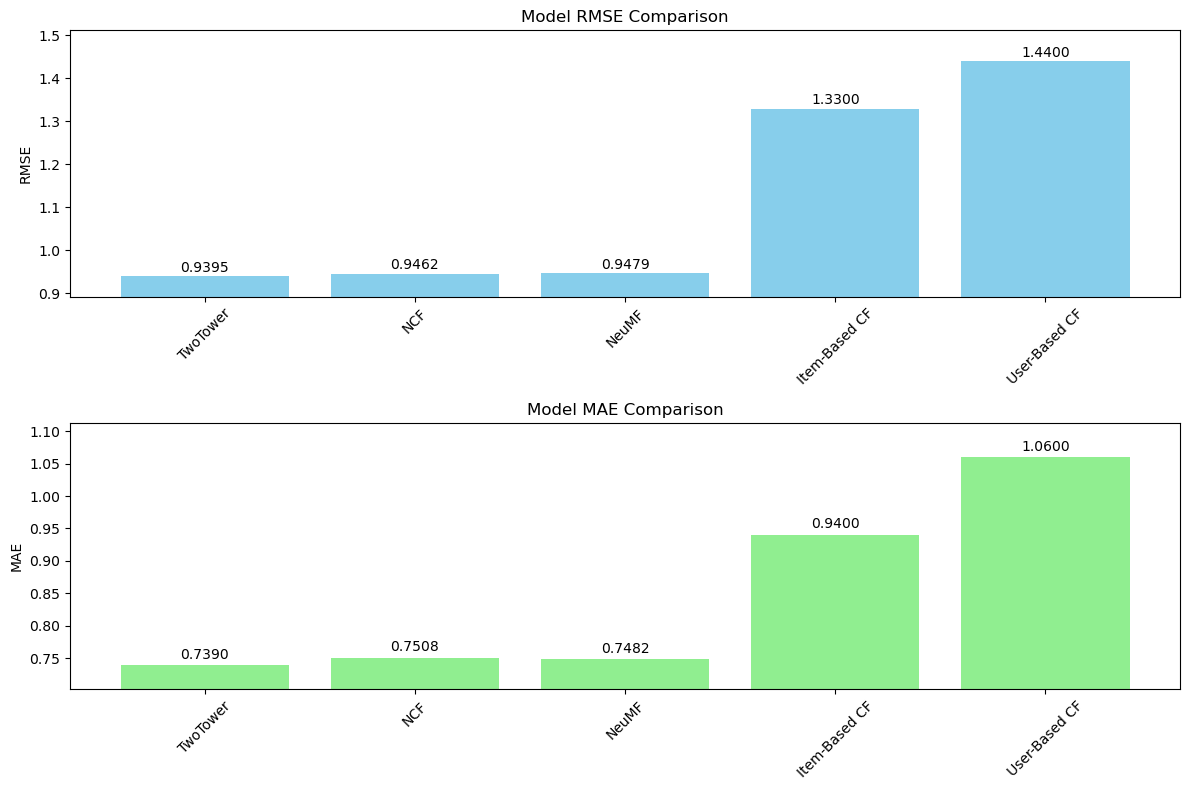


Best model is TwoTower with RMSE: 0.9395

Top 10 Recommendations for User 1 (TwoTower model):
1. Godfather, The (1972) - Predicted Rating: 4.88
2. Someone Else's America (1995) - Predicted Rating: 4.86
3. Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991) - Predicted Rating: 4.86
4. E.T. the Extra-Terrestrial (1982) - Predicted Rating: 4.76
5. Entertaining Angels: The Dorothy Day Story (1996) - Predicted Rating: 4.76
6. Pather Panchali (1955) - Predicted Rating: 4.75
7. Hugo Pool (1997) - Predicted Rating: 4.75
8. Faust (1994) - Predicted Rating: 4.75
9. Gabbeh (1996) - Predicted Rating: 4.74
10. Some Mother's Son (1996) - Predicted Rating: 4.72


In [1]:
# Step 1: Install TensorFlow if not available
try:
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
except ImportError:
    print("Installing TensorFlow...")
    !pip install tensorflow
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")

# Step 2: Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Multiply, Dot, Concatenate, Layer
from tensorflow.keras.models import save_model, load_model
import os
import shutil
import time
import pickle

# Configuration
CONTINUE_TRAINING = True  # Set to False to train from scratch
MODEL_DIR = 'saved_models'
os.makedirs(MODEL_DIR, exist_ok=True)

# ----------------------------------------------------
# Custom Scaling Layer (Fixes serialization issue)
# ----------------------------------------------------
class RatingScaler(Layer):
    def __init__(self, min_rating, max_rating, **kwargs):
        super(RatingScaler, self).__init__(**kwargs)
        self.min_rating = min_rating
        self.max_rating = max_rating
        
    def call(self, inputs):
        return inputs * (self.max_rating - self.min_rating) + self.min_rating
        
    def get_config(self):
        config = super(RatingScaler, self).get_config()
        config.update({
            'min_rating': self.min_rating,
            'max_rating': self.max_rating
        })
        return config

# ----------------------------------------------------
# 1. Data Preparation and Optimization
# ----------------------------------------------------
print("Loading and preparing data...")
ratings = pd.read_csv('../data/ratings_clean.csv')

# Get rating range for constraint
MIN_RATING = ratings['rating'].min()
MAX_RATING = ratings['rating'].max()
print(f"Rating range: {MIN_RATING} to {MAX_RATING}")

# Create optimized mappings for user and movie IDs
user_ids = ratings['user_id'].unique()
movie_ids = ratings['movie_id'].unique()

user_id_to_idx = {user_id: idx for idx, user_id in enumerate(user_ids)}
movie_id_to_idx = {movie_id: idx for idx, movie_id in enumerate(movie_ids)}

# Add mapped indices to dataframe
ratings['user_idx'] = ratings['user_id'].map(user_id_to_idx)
ratings['movie_idx'] = ratings['movie_id'].map(movie_id_to_idx)

# Split data with stratification
train_df, test_df = train_test_split(
    ratings,
    test_size=0.2,
    stratify=ratings['user_id'],
    random_state=42
)

print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

# Save mappings for later use
mappings = {
    'user_id_to_idx': user_id_to_idx,
    'movie_id_to_idx': movie_id_to_idx,
    'min_rating': MIN_RATING,
    'max_rating': MAX_RATING
}
with open(os.path.join(MODEL_DIR, 'mappings.pkl'), 'wb') as f:
    pickle.dump(mappings, f)

# ----------------------------------------------------
# 2. Model Definitions with Custom Scaling Layer
# ----------------------------------------------------
def create_ncf_model(num_users, num_items, embedding_size=64, hidden_units=[128, 64], load_existing=False):
    """Neural Collaborative Filtering Model"""
    model_path = os.path.join(MODEL_DIR, 'ncf_model.keras')
    
    if load_existing and os.path.exists(model_path):
        print("Loading existing NCF model...")
        return load_model(model_path, custom_objects={'RatingScaler': RatingScaler})
    
    # Input layers
    user_input = tf.keras.layers.Input(shape=(1,), name='user_input')
    item_input = tf.keras.layers.Input(shape=(1,), name='item_input')
    
    # Embedding layers with regularization
    user_embedding = tf.keras.layers.Embedding(
        input_dim=num_users, 
        output_dim=embedding_size, 
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        name='user_embedding'
    )(user_input)
    
    item_embedding = tf.keras.layers.Embedding(
        input_dim=num_items, 
        output_dim=embedding_size, 
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        name='item_embedding'
    )(item_input)
    
    # Flatten embeddings
    user_vec = tf.keras.layers.Flatten()(user_embedding)
    item_vec = tf.keras.layers.Flatten()(item_embedding)
    
    # Concatenate embeddings
    concat = tf.keras.layers.Concatenate()([user_vec, item_vec])
    
    # Add hidden layers with batch normalization
    x = concat
    for units in hidden_units:
        x = tf.keras.layers.Dense(units, activation='relu')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.3)(x)
    
    # Output layer
    output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Add scaling layer
    output = RatingScaler(min_rating=MIN_RATING, max_rating=MAX_RATING)(output)
    
    # Create model
    model = tf.keras.Model(inputs=[user_input, item_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

def create_neumf_model(num_users, num_items, mf_dim=64, mlp_layers=[128, 64], load_existing=False):
    """Neural Matrix Factorization model"""
    model_path = os.path.join(MODEL_DIR, 'neumf_model.keras')
    
    if load_existing and os.path.exists(model_path):
        print("Loading existing NeuMF model...")
        return load_model(model_path, custom_objects={'RatingScaler': RatingScaler})
    
    # Input layers
    user_input = Input(shape=(1,), name='user_input')
    item_input = Input(shape=(1,), name='item_input')
    
    # Matrix Factorization (MF) branch
    mf_user_embedding = tf.keras.layers.Embedding(
        num_users, mf_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(user_input)
    mf_item_embedding = tf.keras.layers.Embedding(
        num_items, mf_dim,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(item_input)
    mf_vector = Multiply()([mf_user_embedding, mf_item_embedding])
    mf_vector = tf.keras.layers.Flatten()(mf_vector)
    
    # Multi-Layer Perceptron (MLP) branch
    mlp_user_embedding = tf.keras.layers.Embedding(
        num_users, mlp_layers[0]//2,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(user_input)
    mlp_item_embedding = tf.keras.layers.Embedding(
        num_items, mlp_layers[0]//2,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(item_input)
    mlp_vector = Concatenate()([mlp_user_embedding, mlp_item_embedding])
    mlp_vector = tf.keras.layers.Flatten()(mlp_vector)
    
    for units in mlp_layers:
        mlp_vector = tf.keras.layers.Dense(units, activation='relu')(mlp_vector)
        mlp_vector = tf.keras.layers.BatchNormalization()(mlp_vector)
        mlp_vector = tf.keras.layers.Dropout(0.3)(mlp_vector)
    
    # Combine MF and MLP branches
    neumf_vector = Concatenate()([mf_vector, mlp_vector])
    
    # Output layer
    output = tf.keras.layers.Dense(1, activation='sigmoid')(neumf_vector)
    
    # Add scaling layer
    output = RatingScaler(min_rating=MIN_RATING, max_rating=MAX_RATING)(output)
    
    model = tf.keras.Model(inputs=[user_input, item_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

def create_two_tower_model(num_users, num_items, embedding_size=64, tower_units=[128, 64], load_existing=False):
    """Two-Tower model without feature inputs"""
    model_path = os.path.join(MODEL_DIR, 'two_tower_model.keras')
    
    if load_existing and os.path.exists(model_path):
        print("Loading existing Two-Tower model...")
        return load_model(model_path, custom_objects={'RatingScaler': RatingScaler})
    
    # User tower
    user_input = Input(shape=(1,))
    user_embed = tf.keras.layers.Embedding(
        num_users, embedding_size,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(user_input)
    user_vec = tf.keras.layers.Flatten()(user_embed)
    for units in tower_units:
        user_vec = tf.keras.layers.Dense(units, activation='relu')(user_vec)
        user_vec = tf.keras.layers.BatchNormalization()(user_vec)
        user_vec = tf.keras.layers.Dropout(0.3)(user_vec)
    
    # Item tower
    item_input = Input(shape=(1,))
    item_embed = tf.keras.layers.Embedding(
        num_items, embedding_size,
        embeddings_regularizer=tf.keras.regularizers.l2(1e-6)
    )(item_input)
    item_vec = tf.keras.layers.Flatten()(item_embed)
    for units in tower_units:
        item_vec = tf.keras.layers.Dense(units, activation='relu')(item_vec)
        item_vec = tf.keras.layers.BatchNormalization()(item_vec)
        item_vec = tf.keras.layers.Dropout(0.3)(item_vec)
    
    # Combine towers via dot product
    merged = Dot(axes=1, normalize=False)([user_vec, item_vec])
    
    # Output layer
    output = tf.keras.layers.Dense(1, activation='sigmoid')(merged)
    
    # Add scaling layer
    output = RatingScaler(min_rating=MIN_RATING, max_rating=MAX_RATING)(output)
    
    model = tf.keras.Model(inputs=[user_input, item_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    return model

# ----------------------------------------------------
# 3. Model Training Setup
# ----------------------------------------------------
# Model parameters
num_users = len(user_ids)
num_movies = len(movie_ids)
embedding_size = 64
hidden_units = [128, 64]

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Define models to train
models_to_train = {
    'NCF': create_ncf_model,
    'NeuMF': create_neumf_model,
    'TwoTower': create_two_tower_model
}

# Store results
results = {}
histories = {}
trained_models = {}

# ----------------------------------------------------
# 4. Train and Evaluate All Models
# ----------------------------------------------------
print("\n" + "="*50)
print("TRAINING ALL MODELS")
print("="*50)
print(f"Training mode: {'CONTINUE' if CONTINUE_TRAINING else 'FRESH START'}")

for model_name, model_creator in models_to_train.items():
    print(f"\n{'='*30}")
    print(f"Processing {model_name} model")
    print(f"{'='*30}")
    
    # Create/load model
    model = model_creator(num_users, num_movies, embedding_size, hidden_units, 
                         load_existing=CONTINUE_TRAINING)
    
    # Check if model has training history
    initial_epoch = 0
    if CONTINUE_TRAINING and hasattr(model, 'history') and model.history is not None:
        initial_epoch = len(model.history.epoch)
        print(f"Resuming training from epoch {initial_epoch}")
    else:
        print("Starting fresh training")
    
    model.summary()
    
    # Train model
    start_time = time.time()
    history = model.fit(
        x=[train_df['user_idx'].values, train_df['movie_idx'].values],
        y=train_df['rating'].values,
        batch_size=512,
        epochs=initial_epoch + 50,  # Train for additional 50 epochs
        initial_epoch=initial_epoch,
        validation_split=0.1,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Save model after training
    model_path = os.path.join(MODEL_DIR, f'{model_name.lower()}_model.keras')
    model.save(model_path)
    print(f"Saved {model_name} model as {model_path}")
    
    # Evaluate model
    test_predictions = model.predict(
        [test_df['user_idx'].values, test_df['movie_idx'].values]
    ).flatten()
    
    # Ensure predictions are within rating range
    test_predictions = np.clip(test_predictions, MIN_RATING, MAX_RATING)
    
    test_rmse = np.sqrt(mean_squared_error(test_df['rating'], test_predictions))
    test_mae = mean_absolute_error(test_df['rating'], test_predictions)
    
    # Store results
    results[model_name] = {'RMSE': test_rmse, 'MAE': test_mae}
    histories[model_name] = history.history
    trained_models[model_name] = model
    
    training_time = time.time() - start_time
    print(f"\n{model_name} PERFORMANCE")
    print("="*50)
    print(f"Training time: {training_time:.1f} seconds")
    print(f"Total epochs: {len(history.epoch)}")
    print(f"RMSE: {test_rmse:.4f}")
    print(f"MAE: {test_mae:.4f}")
    print("="*50)

# ----------------------------------------------------
# 5. Training History Visualization
# ----------------------------------------------------
plt.figure(figsize=(15, 10))

# Loss comparison
plt.subplot(2, 2, 1)
for model_name, history in histories.items():
    plt.plot(history['loss'], label=f'{model_name} Train')
plt.title('Training Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Validation Loss comparison
plt.subplot(2, 2, 2)
for model_name, history in histories.items():
    plt.plot(history['val_loss'], label=f'{model_name} Validation')
plt.title('Validation Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# MAE comparison
plt.subplot(2, 2, 3)
for model_name, history in histories.items():
    plt.plot(history['mae'], label=f'{model_name} Train')
plt.title('Training MAE Comparison')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

# Validation MAE comparison
plt.subplot(2, 2, 4)
for model_name, history in histories.items():
    plt.plot(history['val_mae'], label=f'{model_name} Validation')
plt.title('Validation MAE Comparison')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.savefig('model_training_comparison.png', dpi=300)
plt.show()

# ----------------------------------------------------
# 6. Performance Comparison with Baselines
# ----------------------------------------------------
# Load baseline results from CSV if exists, else use defaults
baseline_path = 'model_performance_comparison.csv'
if os.path.exists(baseline_path):
    print("Loading baseline results from existing file...")
    baseline_df = pd.read_csv(baseline_path)
    baseline_results = {}
    for _, row in baseline_df.iterrows():
        baseline_results[row['Model']] = {'RMSE': row['RMSE'], 'MAE': row['MAE']}
else:
    print("Using default baseline values")
    baseline_results = {
        'User-Based CF': {'RMSE': 1.44, 'MAE': 1.06},
        'Item-Based CF': {'RMSE': 1.33, 'MAE': 0.94}
    }

# Combine all results
all_results = {**baseline_results, **results}

# Calculate improvement metrics
comparison_data = []
for model_name, metrics in all_results.items():
    rmse = metrics['RMSE']
    mae = metrics['MAE']
    
    # Calculate improvements over User-Based CF
    if model_name != 'User-Based CF' and 'User-Based CF' in baseline_results:
        ub_rmse = baseline_results['User-Based CF']['RMSE']
        ub_mae = baseline_results['User-Based CF']['MAE']
        rmse_imp = ((ub_rmse - rmse) / ub_rmse) * 100
        mae_imp = ((ub_mae - mae) / ub_mae) * 100
    else:
        rmse_imp = 0
        mae_imp = 0
    
    comparison_data.append({
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'RMSE_Improvement': rmse_imp,
        'MAE_Improvement': mae_imp
    })

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_data)

# Sort by RMSE (best first)
comparison_df = comparison_df.sort_values('RMSE')

print("\nMODEL PERFORMANCE COMPARISON")
print("=" * 85)
print(f"{'Model':<20} | {'RMSE':<10} | {'MAE':<10} | {'RMSE % Improvement':<20} | {'MAE % Improvement':<20}")
print("=" * 85)

for _, row in comparison_df.iterrows():
    rmse_imp_str = f"{row['RMSE_Improvement']:.1f}% vs User-Based" if row['Model'] != 'User-Based CF' else "-"
    mae_imp_str = f"{row['MAE_Improvement']:.1f}% vs User-Based" if row['Model'] != 'User-Based CF' else "-"
    
    print(f"{row['Model']:<20} | {row['RMSE']:<10.4f} | {row['MAE']:<10.4f} | "
          f"{rmse_imp_str:<20} | {mae_imp_str:<20}")

print("=" * 85)

# Save comprehensive results
comparison_df.to_csv('all_model_performance_comparison.csv', index=False)
print("\nResults saved to 'all_model_performance_comparison.csv'")

# Visual comparison
plt.figure(figsize=(12, 8))

# RMSE comparison
plt.subplot(2, 1, 1)
plt.bar(comparison_df['Model'], comparison_df['RMSE'], color='skyblue')
plt.title('Model RMSE Comparison')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.ylim(comparison_df['RMSE'].min()*0.95, comparison_df['RMSE'].max()*1.05)
for i, v in enumerate(comparison_df['RMSE']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

# MAE comparison
plt.subplot(2, 1, 2)
plt.bar(comparison_df['Model'], comparison_df['MAE'], color='lightgreen')
plt.title('Model MAE Comparison')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.ylim(comparison_df['MAE'].min()*0.95, comparison_df['MAE'].max()*1.05)
for i, v in enumerate(comparison_df['MAE']):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300)
plt.show()

# ----------------------------------------------------
# 7. Generate Recommendations with Best Model
# ----------------------------------------------------
# Identify best model by RMSE
best_model_name = comparison_df.iloc[0]['Model']

# Only use neural models for recommendations (skip baselines)
if best_model_name in trained_models:
    best_model = trained_models[best_model_name]
    print(f"\nBest model is {best_model_name} with RMSE: {comparison_df.iloc[0]['RMSE']:.4f}")

    # Load movie titles
    movies = pd.read_csv('../data/movies_clean.csv')
    movie_id_to_title = dict(zip(movies['movie_id'], movies['title']))

    def generate_recommendations(user_id, model, top_n=10):
        """Generate personalized movie recommendations using specified model"""
        if user_id not in user_id_to_idx:
            print(f"User {user_id} not found in training data")
            return []
        
        user_idx = user_id_to_idx[user_id]
        user_indices = np.full(len(movie_id_to_idx), user_idx)
        movie_indices = np.array(list(movie_id_to_idx.values()))
        
        # Predict ratings for all movies
        predictions = model.predict([user_indices, movie_indices], verbose=0).flatten()
        
        # Clip predictions to valid rating range
        predictions = np.clip(predictions, MIN_RATING, MAX_RATING)
        
        # Get top N predictions
        top_indices = predictions.argsort()[::-1][:top_n]
        
        recommendations = []
        for idx in top_indices:
            movie_id = list(movie_id_to_idx.keys())[idx]
            recommendations.append((movie_id, predictions[idx]))
        
        return recommendations

    # Sample recommendations using best model
    sample_user = 1
    recommendations = generate_recommendations(sample_user, best_model)

    print(f"\nTop 10 Recommendations for User {sample_user} ({best_model_name} model):")
    for i, (movie_id, rating) in enumerate(recommendations, 1):
        title = movie_id_to_title.get(movie_id, f"Movie ID {movie_id}")
        print(f"{i}. {title} - Predicted Rating: {rating:.2f}")
else:
    print(f"\nBest model is {best_model_name} (baseline), skipping neural recommendations")